In [1]:
__nbid__ = '0020'
__author__ = 'Michael Balogh <mbalogh@uwaterloo.ca>, Alice Jacques <alice.jacques@noirlab.edu>, Robert Nikutta <robert.nikutta@noirlab.edu>'
__version__ = '20250723' # yyyymmdd
__datasets__ = ['gogreen_dr2']
__keywords__ = ['gemini llp', 'tap', 'cluster', 'photometry', 'redshift', 'file service', 'spectra', 'catalogues']

# GOGREEN Data Release 2 data access at Astro Data Lab

*Authors: Michael Balogh (GOGREEN), Alice Jacques (NOIRLab Astro Data Lab), Robert Nikutta (NOIRLab Astro Data Lab)*

This notebook is adapted from the original version produced by the GOGREEN survey team. The original can be found in `Scripts/DR2_Notebook.ipynb`.

While the original notebook relies on local access to the data files and catalogues, this Data Lab modifed notebook loads the catalogs through a TAP service (using simple SQL queries), and accesses all needed data files (FITS files with 1-d and 2-d spectra, images, etc.) through the Data Lab file service for GOGREEN DR2.

**Note:** Astro Data Lab also hosts GOGREEN DR1. However, GOGREEN DR2 supersedes the DR1 version and should be used for any and all science cases.

# Table of contents
* [Disclaimer & attribution](#attribution)
* [Imports & Config](#imports)
* [Jupyter & Pandas primer](#primer)
* [File access at Data Lab](#fileaccess)
* [Reading in catalogs from TAP](#tap)
* [Merging tables](#merge)
* [Plots](#plots)
  * [Velocity dispersion vs redshift, dynamical mass vs redshfit](#plots-velocity)
  * [UVJ colours with membership](#plots-colors)
  * [Compare spectroscopic and photometric redshifts](#plots-compare-redshifts)
  * [Redshift success](#plots-redshift-success)
  * [Stellar mass and redshift distribution](#plots-mstar-zdistro)
  * [Completeness plots](#plots-completeness)
  * [Spectrum](#plots-spectrum)
  * [Redshift success as a function of spectral SNR](#plots-redshift-success-vs-snr)
  * [Redshift success Part II](#plots-redshift-success-2)
  * [S/N as a function of magnitude for different populations of galaxies](#plots-snr-vs-mag)
  * [Plot summary of object data](#plots-summary-object)

<a class="anchor" id="attribution"></a>
# Disclaimer & attribution

Disclaimers
-----------
Note that using the Astro Data Lab constitutes your agreement with our minimal [Disclaimers](https://datalab.noirlab.edu/about/disclaimers).

Acknowledgments
---------------
If you use **Astro Data Lab** in your published research, please include the text in your paper's Acknowledgments section:

_This research uses services or data provided by the Astro Data Lab, which is part of the Community Science and Data Center (CSDC) Program of NSF NOIRLab. NOIRLab is operated by the Association of Universities for Research in Astronomy (AURA), Inc. under a cooperative agreement with the U.S. National Science Foundation._

If you use **SPARCL jointly with the Astro Data Lab platform** (via JupyterLab, command-line, or web interface) in your published research, please include this text below in your paper's Acknowledgments section:

_This research uses services or data provided by the SPectra Analysis and Retrievable Catalog Lab (SPARCL) and the Astro Data Lab, which are both part of the Community Science and Data Center (CSDC) Program of NSF NOIRLab. NOIRLab is operated by the Association of Universities for Research in Astronomy (AURA), Inc. under a cooperative agreement with the U.S. National Science Foundation._

In either case **please cite the following papers**:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, https://doi.org/10.1117/12.2057445

* Astro Data Lab overview: Nikutta et al., "Data Lab - A Community Science Platform", Astronomy and Computing, 33, 2020, https://doi.org/10.1016/j.ascom.2020.100411

If you are referring to the Data Lab JupyterLab / Jupyter Notebooks, cite:

* Juneau et al., "Jupyter-Enabled Astrophysical Analysis Using Data-Proximate Computing Platforms", CiSE, 23, 15, 2021, https://doi.org/10.1109/MCSE.2021.3057097

If publishing in a AAS journal, also add the keyword: `\facility{Astro Data Lab}`

And if you are using SPARCL, please also add `\software{SPARCL}` and cite:

* Juneau et al., "SPARCL: SPectra Analysis and Retrievable Catalog Lab", Conference Proceedings for ADASS XXXIII, 2024
https://doi.org/10.48550/arXiv.2401.05576

The NOIRLab Library maintains [lists of proper acknowledgments](https://noirlab.edu/science/about/scientific-acknowledgments) to use when publishing papers using the Lab's facilities, data, or services.

<a class="anchor" id="imports"></a>
# Imports & Config

In [2]:
# std lib
from io import BytesIO
import gzip

# 3rd party
import numpy as np
np.seterr(divide='ignore',invalid='ignore')

import pandas as pd
pd.set_option('display.max_columns', 500)

import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

from astropy.io import fits, ascii
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3) # define cosmology

# Data Lab
from dl import queryClient as qc, storeClient as sc

<a class="anchor" id="primer"></a>
# Jupyter & Pandas primer

**Brief introduction to ipython notebooks/jupyter**

See also: http://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/
Short video: https://www.youtube.com/watch?v=jZ952vChhuI

Executing basics:
    - There are two modes, command mode and edit mode. 
        - If you have selected a cell and see a cursor, you are in edit mode (the cell will be outlined in green). 
        - If the cell is outlined in blue, you are in command mode. 
        - To toggle between modes, hit escape, or click on the margin of the cell.

    -  **************** Run a cell, in either mode: shift + enter ****************
        - Notice that the cell number will change. Jupyter doesn't care what order the cells are in, it cares what order you execute them in. Pay attention to where you have defined variables.
        
    - Command mode has some shortcuts for the keys:
        - x - cut. This is also delete, if you don't remember to paste. There are limited undo's under the Edit menu
        - c - copy
        - v - paste
        
    See tool bar for more options. Keyboard shortcuts listed in Help>Keyboard shortcuts (shortcut 'h')
    
Helpful tips:
    You can check the requirements for a package by typing (for example)
    > help(np.arange)
    or 
    > np.arange? # this makes a popout window
    
    you can also use the tab key to see available options 
    > np.arange(<tab>
    
There are also multiple types of cells. This cell is a 'Raw NBConvert' type cell, which is not executable.
    - code (y) - executable in python
    - markdown (m) - renders markdown type, usefule for headings,tables,equations
    - raw NBConvert (r) - non executable
    - headings (1-6) - markdown with quick heading setup
    
    - you may accidentally switch cell types while in command mode. You can check the cell type from the drop down menu in the tool bar.




**Brief introduction to pandas:**
See also: https://pandas.pydata.org/ 

https://pandas.pydata.org/pandas-docs/stable/10min.html

Pandas uses Series and DataFrame structures. It is much like astropy.table.Table, or numpy tables, but has convenient indexing which helps agaist misaligning columns/rows.

When retrieve elements in a column, 

    column = table['column_header'] 
        (alternatively, table.column_header, if column_header is not also a key word)
    this is a Series, which retains the indexing of the dataframe
    
    
    to convert to an array:
    column = table['column_header'].values
    
To access a specific row and column:

    object = table.loc[row_index,'column_header']
    
To access all indices in the dataframe:

    indices = table.index
    
Convenient functions:

    table.query('column_header > 0')
    returns a 'dataframe' slice, maintaining the index structure of the parent dataframe
    
    equivalent to, but cleaner than: table[table['column_header'] > 0]

<a class="anchor" id="fileaccess"></a>
# File access to GOGREEN DR2 data products at Data Lab

All GOGREEN DR2 data products, in their original form, reside at Data Lab in a so-called file service, or "public VOSpace". To explore the file service and its contents, use the Data Lab `storeClient` (imported as `sc`):

In [3]:
print(sc.services('gogreen_dr2'))


                    name   svc   description
                --------   ----  --------
             gogreen_dr2   vos   GOGREEN DR2 Survey



To list the contents of the top-level directory, use the `storeClient.ls()` method:

In [4]:
print(sc.ls('gogreen_dr2://',format='long'))

drwxrwxr-x  gogreen_dr2       0  13 May 2025 13:46  CATS/
-rw-rw-r-x  gogreen_dr2  239571  13 May 2025 13:46  GOGREEN_and_GCLASS_Data_Release_DR2.pdf
drwxrwxr-x  gogreen_dr2       0  13 May 2025 13:46  PHOTOMETRY/
-rw-rw-r-x  gogreen_dr2     520  13 May 2025 13:46  README
drwxrwxr-x  gogreen_dr2       0  13 May 2025 13:46  SPECTROSCOPY/
drwxrwxr-x  gogreen_dr2       0  13 May 2025 13:46  Scripts/



To list subdirectories, you can simply do:

In [5]:
print(sc.ls('gogreen_dr2://SPECTROSCOPY/OneD',format='long'))

-rw-rw-r-x  gogreen_dr2  2793600  13 May 2025 13:46  COSMOS-125_final.fits
-rw-rw-r-x  gogreen_dr2  3438720  13 May 2025 13:46  COSMOS-221_final.fits
-rw-rw-r-x  gogreen_dr2  2833920  13 May 2025 13:46  COSMOS-28_final.fits
-rw-rw-r-x  gogreen_dr2  1379520  13 May 2025 13:46  COSMOS-63_final.fits
-rw-rw-r-x  gogreen_dr2     174  13 May 2025 13:46  README
-rw-rw-r-x  gogreen_dr2  3720960  13 May 2025 13:46  SPT0205_final.fits
-rw-rw-r-x  gogreen_dr2  4728960  13 May 2025 13:46  SPT0546_final.fits
-rw-rw-r-x  gogreen_dr2  3358080  13 May 2025 13:46  SPT2106_final.fits
-rw-rw-r-x  gogreen_dr2  5011200  13 May 2025 13:46  SXDF49_final.fits
-rw-rw-r-x  gogreen_dr2  1137600  13 May 2025 13:46  SXDF64_final.fits
-rw-rw-r-x  gogreen_dr2  4245120  13 May 2025 13:46  SXDF76_final.fits
-rw-rw-r-x  gogreen_dr2  4783680  13 May 2025 13:46  SpARCS0034_final.fits
-rw-rw-r-x  gogreen_dr2  5451840  13 May 2025 13:46  SpARCS0035_final.fits
-rw-rw-r-x  gogreen_dr2  4262400  13 May 2025 13:46  SpARCS0036_

In the remainder of this notebook, we will need a few directories repeatedly. Let's define them for convenience:

In [6]:
oneddir = 'gogreen_dr2://SPECTROSCOPY/OneD/'  # 1-d spectra
twoddir = 'gogreen_dr2://SPECTROSCOPY/TwoD/'  # 2-d spectra
imdir = 'gogreen_dr2://PHOTOMETRY/IMAGES/'    # photometry and images

<a class="anchor" id="tap"></a>
# Read in three main tables

GOGREEN Data Release 2 contains three main catalogues:

1. clusters -- Contains information about each of the 26 clusters
2. redshift -- The redshift catalogue, with one entry for each spectrum
3. photo -- The merged photometric catalogue

All three catalogues are loaded in the Data Lab TAP service as queryable tables. You can interact with the tables using the Data Lab `queryClient` (imported as `qc`). Here, let's list some information about the database (also called "schema"): 

In [7]:
print(qc.schema('gogreen_dr2'))


Schema: gogreen_dr2

      Table Name   Description
      ----------   -----------
        clusters   Information relevant to each cluster in system in the GCLA
                   SS and GOGREEN surveys
           photo   Selected photometric data for each cluster system in the G
                   CLASS, GOGREEN samples, COMOS UltraVISTA, and SXDF SPLASH
                   fields
        redshift   Contains an entry for every unique object with a GOGREEN o
                   r GCLASS spectrum
x1p5__photo__allwise__source   gogreen_dr2.photo and xmatch_std.allwise__source crossmatc
                   h (1.5 arcsec)
x1p5__photo__gaia_dr3__gaia_source   gogreen_dr2.photo and xmatch_std.gaia_dr3__gaia_source cro
                   ssmatch (1.5 arcsec)
x1p5__photo__nsc_dr2__object   gogreen_dr2.photo and xmatch_std.nsc_dr2__object crossmatc
                   h (1.5 arcsec)
x1p5__photo__sdss_dr17__specobj   gogreen_dr2.photo and xmatch_std.sdss_dr17__specobj crossm
                   atch

More information about each table:

In [8]:
for table in ('clusters','photo','redshift'):
    print(qc.schema('gogreen_dr2.%s' % table))


Schema: gogreen_dr2
 Table: clusters

     Column Name   Description
     -----------   -----------
          pa_deg   Position angle, in degrees, for the GMOS spectroscopic obs
                   ervations (GOGREEN only).
        redshift   Best estimate of the cluster redshift, based on available 
                   spectroscopy, including publicly available spectra from ot
                   her sources not included in this release.
            elat   Ecliptic latitude
            elon   Ecliptic longitude
            glat   Galactic latitude
            glon   Galactic longitude
      cluster_id   An integer which is used to identify the corresponding pho
                   tometry. It is a unique number for each SpARCS and SPT clu
                   ster; it is 14 for all COSMOS clusters and 13 for those in
                   the SXDF.
            htm9   HTM index (order 9 => ~10 arcmin size)
        nest4096   HEALPIX index (Nsides 4096, Nest scheme => ~52 arcsec size)
         

Each table can be queried using either SQL (Postgres flavor) or ADQL.
For the purpose of this notebook we will query and load the entire tables.

First, the `clusters` table:

(The Data Lab queryClient `query` method can convert the query result to various formats on the fly,
e.g. to a Pandas data frame)

In [9]:
cluster_table = qc.query('select * from gogreen_dr2.clusters',fmt='pandas')
print("Column names:", cluster_table.columns)
cluster_table.head(10)  # first 10 rows of the table

Column names: Index(['pa_deg', 'redshift', 'elat', 'elon', 'glat', 'glon', 'cluster_id',
       'htm9', 'nest4096', 'ring256', 'dec_best', 'ra_best', 'ra_gmos',
       'dec_gmos', 'random_id', 'vdisp', 'vdisp_err', 'cluster', 'fullname',
       'gclass_m1', 'gclass_m2', 'gclass_m3', 'gclass_m4', 'gclass_m5',
       'gogreen_m1', 'gogreen_m2', 'gogreen_m3', 'gogreen_m4', 'gogreen_m5',
       'gogreen_m6', 'image_b', 'image_g', 'image_i', 'image_irac1', 'image_j',
       'image_j1', 'image_k', 'image_r', 'image_u', 'image_v', 'image_y',
       'image_z', 'kphot_cat', 'photoz_cat', 'preimage', 'stelmass_cat'],
      dtype='object')


,pa_deg,redshift,elat,elon,glat,glon,cluster_id,htm9,nest4096,ring256,dec_best,ra_best,ra_gmos,dec_gmos,random_id,vdisp,vdisp_err,cluster,fullname,gclass_m1,gclass_m2,gclass_m3,gclass_m4,gclass_m5,gogreen_m1,gogreen_m2,gogreen_m3,gogreen_m4,gogreen_m5,gogreen_m6,image_b,image_g,image_i,image_irac1,image_j,image_j1,image_k,image_r,image_u,image_v,image_y,image_z,kphot_cat,photoz_cat,preimage,stelmass_cat
0,0.0,1.156,73.719807,209.004945,43.629341,85.567791,10,3515738,41608482,67843,55.753400,244.17220,244.17180,55.757137,51.660860,782.0,39,SpARCS1616,SpARCS J1616+5545,GN2009AQ001-01,GN2009AQ001-02,GN2009AQ001-03,GN2010AQ00-06,GN2010AQ001-07,GN2016ALP004-06,GN2016ALP004-07,GN2017ALP004-09,GN2018ALP004-08,NaN,NaN,NaN,mos_Suprimeg_3,mos_Suprimei_3,mos_IRAC1_3,mos_WIRCamJ_3,NaN,mos_WIRCamK_3,mos_Suprimer_3,mos_MegaCamu_3,NaN,mos_HSCy_3,mos_HSCz_3,SpARCS-1616_totalall_WIRCamK.cat,SpARCS-1616_totalall_Ks.zout,mfrgN20150514S0083_add,SpARCS-1616_totalall_Ks.fout
1,NaN,0.871,74.240027,205.192905,43.768608,87.179267,19,3517590,47205462,64207,56.825000,243.31100,NaN,NaN,88.079790,1350.0,100,SpARCS1613,SpARCS J1613+5649,GN2010AQ001-04,GN2010AQ001-05,GN2009AQ001-08,GN2009AQ001-09,GN2009AQ001-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mos_g,mos_i,mos_IRAC1,mos_J,NaN,mos_K,mos_r,mos_u,NaN,NaN,mos_z,SpARCS-1613_v2.0.cat,SpARCS-1613_v2.0.zout,NaN,SpARCS-1613_v2.0.fout
2,90.0,1.035,45.954763,136.219739,52.438823,148.513716,9,3784504,24868666,58449,58.300750,162.79675,162.80917,58.308537,37.877510,689.0,36,SpARCS1051,SpARCS J1051+5818,GN2010AQ001-07,GN2010BQ037-07,GN2010AQ001-01,GN2010AQ001-02,NaN,GN2016ALP004-03,GN2017ALP004-07,GN2017ALP004-08,GN2018ALP004-07,NaN,NaN,NaN,mos_Suprimeg_3,mos_Suprimei_3,mos_IRAC1_3,mos_WIRCamJ_3,NaN,mos_WIRCamK_3,mos_Suprimer_3,mos_MegaCamu_3,NaN,mos_HSCy_3,mos_HSCz_3,SpARCS-1051_totalall_WIRCamK.cat,SpARCS-1051_totalall_Ks.zout,mfrgN20150508S0100_add,SpARCS-1051_totalall_Ks.fout
3,90.0,1.385,44.812927,133.627443,50.796211,150.745802,8,3780883,24885045,58441,58.309190,158.70600,158.70600,58.309170,5.635609,250.0,28,SpARCS1034,SpARCS J1034+5818,NaN,NaN,NaN,NaN,NaN,GN2017BDD012-01,GN2018ALP004-04,GN2018ALP004-05,GN2018ALP004-06,GN2017ALP004-04,GN2017ALP004-05,NaN,mos_Suprimeg_3,mos_Suprimei_3,mos_IRAC1_3,mos_WIRCamJ_3,NaN,mos_WIRCamK_3,mos_Suprimer_3,NaN,NaN,mos_HSCy_3,mos_HSCz_3,SpARCS-1034_totalall_WIRCamK.cat,SpARCS-1034_totalall_Ks.zout,mfrgN20150328S0192_add,SpARCS-1034_totalall_Ks.fout
4,0.0,1.461,44.358819,133.711844,50.903693,151.451085,7,3784228,24884272,59816,57.890000,158.35650,158.35650,57.890000,13.064641,955.0,86,SpARCS1033,SpARCS J1033+5753,NaN,NaN,NaN,NaN,NaN,GN2017ALP004-02,GN2017ALP004-03,GN2018ALP004-01,GN2018ALP004-02,GN2018ALP004-03,GN2017ALP004-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SpARCS-1033_totalall_WIRCamK.cat,SpARCS-1033_totalall_Ks.zout,mfrgN20150329S0129_add,SpARCS-1033_totalall_Ks.fout
5,NaN,0.956,45.178412,136.116788,52.493514,149.790375,18,3784398,24867030,61214,57.687060,161.88930,NaN,NaN,42.756584,660.0,120,SpARCS1047,SpARCS J1047+5741,GN2010BQ037-04,GN2010BQ037-05,GN2010AQ001-03,GN2010BQ037-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mos_g,mos_i,mos_IRAC1,mos_J,NaN,mos_K,mos_r,mos_u,NaN,NaN,mos_z,SpARCS-1047_v2.0.cat,SpARCS-1047_v2.0.zout,NaN,SpARCS-1047_v2.0.fout
6,NaN,0.869,-43.232457,346.331768,-72.693584,311.813389,16,2329926,144951900,666896,-44.180500,9.18756,NaN,NaN,13.516704,750.0,90,SpARCS0036,SpARCS J0036-4410,GS2009BQ026-01,GS2009BQ026-02,GS2009BQ026-03,GS2009BQ026-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mos_g,mos_i,mos_IRAC1,mos_J,NaN,mos_K,mos_r,mos_u,NaN,NaN,mos_z,SpARCS-0036_v2.0.cat,SpARCS-0036_v2.0.zout,NaN,SpARCS-0036_v2.0.fout
7,NaN,0.867,-42.147761,346.668560,-73.640799,313.829696,15,2329966,145310242,660956,-43.131500,8.67512,NaN,NaN,21.515335,700.0,150,SpARCS0034,SpARCS J0034-4307,GS2009BQ026-05,GS2009BQ026-06,GS2009BQ026-07,GS2009BQ026-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mos_g,mos_i,mos_IRAC1,mos_J,NaN,mos_K,mos_r,mos_u,NaN,NaN,mos_z,SpARCS-0034_v2.0.cat,SpARCS-0034_v2.0.zo

Next, the `photo` table:

In [10]:
phot_table = qc.query('select * from gogreen_dr2.photo',fmt='pandas')
print("Column names:", phot_table.columns)
phot_table.head(10)  # first 10 rows of the table

Column names: Index(['ra', 'dec', 'elat', 'elon', 'glat', 'glon', 'ra_centre', 'dec_centre',
       'b_tot', 'cluster_z', 'eb_tot', 'efuv_tot', 'eg_tot', 'eh_tot',
       'ei_tot', 'eia484_tot', 'eia527_tot', 'eia624_tot', 'eia679_tot',
       'eia738_tot', 'eia767_tot', 'eib427_tot', 'eib464_tot', 'eib505_tot',
       'eib574_tot', 'eib709_tot', 'eib827_tot', 'eirac1_tot', 'eirac2_tot',
       'eirac3_tot', 'eirac4_tot', 'ej_tot', 'ek_tot', 'eks_tot',
       'emips24_tot', 'enuv_tot', 'er_tot', 'eu_tot', 'ev_tot', 'ey_tot',
       'ez_tot', 'fuv_tot', 'g_tot', 'h_tot', 'i_tot', 'ia484_tot',
       'ia527_tot', 'ia624_tot', 'ia679_tot', 'ia738_tot', 'ia767_tot',
       'ib427_tot', 'ib464_tot', 'ib505_tot', 'ib574_tot', 'ib709_tot',
       'ib827_tot', 'irac1_tot', 'irac2_tot', 'irac3_tot', 'irac4_tot',
       'j_tot', 'k_flag', 'k_tot', 'ks_tot', 'mips24_tot', 'mstellar',
       'nuv_tot', 'nuvminv', 'r_tot', 'redshift_quality', 'star', 'totmask',
       'u_tot', 'uminv', 'v_tot', 'vd

,ra,dec,elat,elon,glat,glon,ra_centre,dec_centre,b_tot,cluster_z,eb_tot,efuv_tot,eg_tot,eh_tot,ei_tot,eia484_tot,eia527_tot,eia624_tot,eia679_tot,eia738_tot,eia767_tot,eib427_tot,eib464_tot,eib505_tot,eib574_tot,eib709_tot,eib827_tot,eirac1_tot,eirac2_tot,eirac3_tot,eirac4_tot,ej_tot,ek_tot,eks_tot,emips24_tot,enuv_tot,er_tot,eu_tot,ev_tot,ey_tot,ez_tot,fuv_tot,g_tot,h_tot,i_tot,ia484_tot,ia527_tot,ia624_tot,ia679_tot,ia738_tot,ia767_tot,ib427_tot,ib464_tot,ib505_tot,ib574_tot,ib709_tot,ib827_tot,irac1_tot,irac2_tot,irac3_tot,irac4_tot,j_tot,k_flag,k_tot,ks_tot,mips24_tot,mstellar,nuv_tot,nuvminv,r_tot,redshift_quality,star,totmask,u_tot,uminv,v_tot,vdisp,vminj,y_tot,z_tot,zphot,zphot_l68,zphot_u68,zspec,zspec_gogreen,cphotid,htm9,nest4096,ring256,specid,random_id,cluster
0,244.312531,55.719582,73.741946,209.301363,43.562927,85.492476,244.1722,55.7534,NaN,1.156,NaN,NaN,0.085843,NaN,0.132667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.761443,0.352293,3.880793,1.233024,0.490534,NaN,0.723538,NaN,NaN,0.084729,0.109255,NaN,0.335570,0.118174,NaN,-0.050168,NaN,0.215166,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.848401,0.464892,0.347833,0.128208,1.002250,0.0,NaN,1.524,NaN,4.897788e+08,NaN,6.913343,0.036790,NaN,0,NaN,-0.076925,2.358,NaN,782.0,1.114,0.675599,0.430332,0.8011,0.5726,1.0456,NaN,NaN,110006980,3515738,41603002,68582,-1,5.957752,SpARCS1616
1,244.311798,55.720600,73.742494,209.297962,43.563040,85.493984,244.1722,55.7534,NaN,1.156,NaN,NaN,0.953982,NaN,1.486726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.026549,-1.907965,-19.079646,-6.591150,5.500885,NaN,8.338053,NaN,NaN,0.941593,1.090265,NaN,3.568142,1.300885,NaN,-0.978761,NaN,-1.040708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.359292,-0.012389,3.109735,2.316814,-3.939823,0.0,NaN,1.400,NaN,1.000000e-01,NaN,NaN,-0.991150,NaN,0,NaN,-0.582301,NaN,NaN,782.0,NaN,4.584071,-0.656637,NaN,NaN,NaN,NaN,NaN,110006942,3515738,41603002,68582,-1,29.849567,SpARCS1616
2,244.312027,55.718090,73.740596,209.303846,43.563614,85.490607,244.1722,55.7534,NaN,1.156,NaN,NaN,0.115540,NaN,0.189065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.267477,1.968681,20.833210,6.821361,0.732253,NaN,1.021854,NaN,NaN,0.120042,0.133546,NaN,0.451656,0.157555,NaN,0.066023,NaN,1.446501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.173059,11.315416,3.466200,0.352622,8.423916,0.0,NaN,13.002,NaN,1.023293e+10,NaN,4.771605,0.528183,NaN,0,NaN,-0.183063,1.867,NaN,782.0,0.692,5.506906,3.380670,1.1842,1.1021,1.2831,NaN,NaN,110007216,3515738,41603000,68582,-1,97.803345,SpARCS1616
3,244.311600,55.719009,73.741171,209.301148,43.563590,85.491918,244.1722,55.7534,NaN,1.156,NaN,NaN,0.116074,NaN,0.180894,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.533280,2.999822,32.913623,10.472242,0.673829,NaN,0.978334,NaN,NaN,0.114566,0.138685,NaN,0.450727,0.158282,NaN,3.536473,NaN,39.867482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.982993,27.066232,2.354634,10.336572,108.185033,0.0,NaN,88.344,NaN,3.715352e+10,NaN,6.040870,12.546491,NaN,1,NaN,0.284908,2.308,NaN,782.0,0.846,81.560483,64.297187,0.5237,0.5041,0.5431,NaN,NaN,110006989,3515738,41603002,68582,-1,62.071686,SpARCS1616
4,244.310471,55.720356,73.741841,209.296395,43.563826,85.493947,244.1722,55.7534,NaN,1.156,NaN,NaN,0.283225,NaN,0.437711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-35.660544,-16.798525,-158.852183,-58.336898,1.611069,NaN,2.350396,NaN,NaN,0.279546,0.323685,NaN,1.051977,0.408285,NaN,0.014713,NaN,-0.018391,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.902613,0.051495,38.294164,15.452289,-0.305294,0.0,NaN,1.589,NaN,1.000000e-01,NaN,NaN,0.213338,NaN,0,NaN,-0.117704,NaN,NaN,782.0,NaN,1.327845,0.102991,NaN,NaN,NaN,NaN,NaN,110006956,3515738,41603002,68582,-1,4.259322,SpARCS1616
5,244.308670,55.717907,73.739287,209.298928,43.565481,85.491090,244.1722,55.7534,NaN,1.156,NaN,NaN,0.271485,NaN,0.454825,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-13.891546,-6.751856,-70.370907,-23.453443,1.685320,NaN,2.376371,NaN,NaN,0.28911

And finally, the `redshift` table:

In [11]:
redshift_table = qc.query('select * from gogreen_dr2.redshift',fmt='pandas')
print("Column names:", redshift_table.columns)
redshift_table.head(10)  # first 10 rows of the table

Column names: Index(['elat', 'elon', 'glat', 'glon', 'htm9', 'nest4096', 'ring256', 'specid',
       'ra', 'dec', 'd4000', 'delta_bic', 'ed4000', 'eewhdelta', 'eewoii',
       'eewoii_model', 'ef_oii', 'esfr_oii', 'ewhdelta', 'ewoii',
       'ewoii_model', 'f_oii', 'member', 'member_clean', 'member_em',
       'random_id', 'redshift', 'sfr_oii', 'snr_8500_rms', 'snr_8500_var',
       'spec_flag', 'extver', 'objclass', 'redshift_quality', 'cluster'],
      dtype='object')


,elat,elon,glat,glon,htm9,nest4096,ring256,specid,ra,dec,d4000,delta_bic,ed4000,eewhdelta,eewoii,eewoii_model,ef_oii,esfr_oii,ewhdelta,ewoii,ewoii_model,f_oii,member,member_clean,member_em,random_id,redshift,sfr_oii,snr_8500_rms,snr_8500_var,spec_flag,extver,objclass,redshift_quality,cluster
0,73.749421,209.165057,43.579158,85.541236,3515738,41608461,67843,210040694,244.26736,55.748990,1.720697,1.034171,0.047523,1.389133,1.904719,0.739854,2.785355e-18,1.072115,2.542908,-0.300046,2.527415,9.666613e-18,0,0,0,67.482280,0.98500,3.720791,5.869843,9.916716,0,190,4,4,SpARCS1616
1,73.748050,209.165898,43.580135,85.539867,3515738,41608461,67843,210040682,244.26619,55.747765,1.151380,15.497870,0.090801,7.363172,10.874112,3.263182,4.744413e-18,1.097008,-0.801108,14.278197,13.661364,2.044749e-17,0,0,0,97.495830,0.98300,4.727888,2.256782,2.369318,0,189,4,3,SpARCS1616
2,73.721717,209.190558,43.597487,85.510907,3515738,41608451,67843,210050317,244.24700,55.722780,1.066279,NaN,0.036692,2.293924,NaN,NaN,NaN,NaN,4.683563,NaN,NaN,NaN,0,0,0,90.166660,0.69900,NaN,2.513325,5.068531,0,215,4,4,SpARCS1616
3,73.713954,209.171247,43.606951,85.510719,3515738,41608451,67843,110000882,244.23093,55.720005,NaN,-9.552340,NaN,NaN,NaN,10.516150,7.775570e-18,3.717828,NaN,NaN,20.818668,1.669888e-17,-1,-1,-1,33.702690,1.07237,7.984437,1.957332,2.271820,0,6,3,2,SpARCS1616
4,73.736071,209.143118,43.593585,85.537376,3515738,41608460,67843,210040592,244.24414,55.742275,1.148239,NaN,0.021180,1.192288,NaN,NaN,NaN,NaN,5.918586,NaN,NaN,NaN,0,0,0,67.919050,0.68000,NaN,3.886507,8.195844,0,183,4,4,SpARCS1616
5,73.739136,209.130828,43.593101,85.543704,3515738,41608460,67843,210040676,244.24269,55.746810,NaN,23.937819,NaN,NaN,NaN,4.982780,3.071787e-18,0.154257,NaN,NaN,20.913225,1.511801e-17,-1,-1,-1,18.708320,1.06300,0.759184,0.941039,1.153891,0,188,4,2,SpARCS1616
6,73.736584,209.127843,43.595662,85.542589,3515738,41608462,67843,110001392,244.23872,55.745320,1.735545,9.195878,0.070965,1.609948,2.339010,0.820255,1.513981e-18,0.631975,9.690684,1.801753,2.788579,5.747672e-18,1,1,1,38.752900,1.15890,2.399229,3.207777,8.056579,0,32,3,4,SpARCS1616
7,73.732744,209.137704,43.597173,85.536399,3515738,41608460,67843,210040570,244.23837,55.740593,1.784196,15.749046,0.050824,1.541471,1.908053,0.633235,1.817778e-18,0.524312,-1.467241,0.028526,2.634937,8.215124e-18,0,0,0,60.415005,0.90400,2.369534,5.426196,10.386764,0,180,4,4,SpARCS1616
8,73.728415,209.125001,43.602764,85.536908,3515738,41608459,67843,210040532,244.22865,55.739384,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,40.980717,0.43400,NaN,21.064764,29.702555,0,179,4,4,SpARCS1616
9,73.729491,209.108348,43.604608,85.543011,3515738,41608459,67843,210050618,244.22331,55.743110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,46.918520,0.33600,NaN,3.294369,10.653121,0,225,4,4,SpARCS1616


<a class="anchor" id="merge"></a>
# Merge tables

Let's now merge the `photo` and `redshift` tables, using the `specid` and `cluster` columns.
This will return a table that has photometric information (if available) for every object in the redshift catalogue.

In [12]:
# this way avoids duplicate columns (ie dont need to specify suffixes)
merge_col = ['specid']
cols_to_use = phot_table.columns.difference(redshift_table.columns).tolist() + merge_col
matched_table = pd.merge(redshift_table, phot_table[cols_to_use], how='left', \
                         left_on=['specid'], right_on=merge_col )
merge_col = ['cluster']

# Here attach suffix _c to distinguish between galaxy values (Redshift) and cluster values (Redshift_c)
matched_table = pd.merge(matched_table, cluster_table, how='left', \
                         left_on=['cluster'], right_on=merge_col, suffixes=['','_c'] )
print("Column names:", matched_table.columns.values)
matched_table.head(20)  # show the first 20 rows of the matched table

Column names: ['elat' 'elon' 'glat' 'glon' 'htm9' 'nest4096' 'ring256' 'specid' 'ra'
 'dec' 'd4000' 'delta_bic' 'ed4000' 'eewhdelta' 'eewoii' 'eewoii_model'
 'ef_oii' 'esfr_oii' 'ewhdelta' 'ewoii' 'ewoii_model' 'f_oii' 'member'
 'member_clean' 'member_em' 'random_id' 'redshift' 'sfr_oii'
 'snr_8500_rms' 'snr_8500_var' 'spec_flag' 'extver' 'objclass'
 'redshift_quality' 'cluster' 'b_tot' 'cluster_z' 'cphotid' 'dec_centre'
 'eb_tot' 'efuv_tot' 'eg_tot' 'eh_tot' 'ei_tot' 'eia484_tot' 'eia527_tot'
 'eia624_tot' 'eia679_tot' 'eia738_tot' 'eia767_tot' 'eib427_tot'
 'eib464_tot' 'eib505_tot' 'eib574_tot' 'eib709_tot' 'eib827_tot'
 'eirac1_tot' 'eirac2_tot' 'eirac3_tot' 'eirac4_tot' 'ej_tot' 'ek_tot'
 'eks_tot' 'emips24_tot' 'enuv_tot' 'er_tot' 'eu_tot' 'ev_tot' 'ey_tot'
 'ez_tot' 'fuv_tot' 'g_tot' 'h_tot' 'i_tot' 'ia484_tot' 'ia527_tot'
 'ia624_tot' 'ia679_tot' 'ia738_tot' 'ia767_tot' 'ib427_tot' 'ib464_tot'
 'ib505_tot' 'ib574_tot' 'ib709_tot' 'ib827_tot' 'irac1_tot' 'irac2_tot'
 'irac3_tot'

,elat,elon,glat,glon,htm9,nest4096,ring256,specid,ra,dec,d4000,delta_bic,ed4000,eewhdelta,eewoii,eewoii_model,ef_oii,esfr_oii,ewhdelta,ewoii,ewoii_model,f_oii,member,member_clean,member_em,random_id,redshift,sfr_oii,snr_8500_rms,snr_8500_var,spec_flag,extver,objclass,redshift_quality,cluster,b_tot,cluster_z,cphotid,dec_centre,eb_tot,efuv_tot,eg_tot,eh_tot,ei_tot,eia484_tot,eia527_tot,eia624_tot,eia679_tot,eia738_tot,eia767_tot,eib427_tot,eib464_tot,eib505_tot,eib574_tot,eib709_tot,eib827_tot,eirac1_tot,eirac2_tot,eirac3_tot,eirac4_tot,ej_tot,ek_tot,eks_tot,emips24_tot,enuv_tot,er_tot,eu_tot,ev_tot,ey_tot,ez_tot,fuv_tot,g_tot,h_tot,i_tot,ia484_tot,ia527_tot,ia624_tot,ia679_tot,ia738_tot,ia767_tot,ib427_tot,ib464_tot,ib505_tot,ib574_tot,ib709_tot,ib827_tot,irac1_tot,irac2_tot,irac3_tot,irac4_tot,j_tot,k_flag,k_tot,ks_tot,mips24_tot,mstellar,nuv_tot,nuvminv,r_tot,ra_centre,star,totmask,u_tot,uminv,v_tot,vdisp,vminj,y_tot,z_tot,zphot,zphot_l68,zphot_u68,zspec,zspec_gogreen,pa_deg,redshift_c,elat_c,elon_c,glat_c,glon_c,cluster_id,htm9_c,nest4096_c,ring256_c,dec_best,ra_best,ra_gmos,dec_gmos,random_id_c,vdisp_c,vdisp_err,fullname,gclass_m1,gclass_m2,gclass_m3,gclass_m4,gclass_m5,gogreen_m1,gogreen_m2,gogreen_m3,gogreen_m4,gogreen_m5,gogreen_m6,image_b,image_g,image_i,image_irac1,image_j,image_j1,image_k,image_r,image_u,image_v,image_y,image_z,kphot_cat,photoz_cat,preimage,stelmass_cat
0,73.749421,209.165057,43.579158,85.541236,3515738,41608461,67843,210040694,244.26736,55.748990,1.720697,1.034171,0.047523,1.389133,1.904719,0.739854,2.785355e-18,1.072115,2.542908,-0.300046,2.527415,9.666613e-18,0,0,0,67.482280,0.98500,3.720791,5.869843,9.916716,0,190,4,4,SpARCS1616,NaN,1.156,110005451.0,55.7534,NaN,NaN,0.129839,NaN,0.218872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.153243,3.453729,13.633140,11.867324,0.740085,NaN,1.131458,NaN,NaN,0.140969,0.200324,NaN,0.367260,0.181775,NaN,0.810569,NaN,13.677656,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,149.341310,106.041716,68.063683,44.759361,69.247077,0.0,NaN,139.889,NaN,9.332543e+10,NaN,4.756246,4.616719,244.1722,0.0,NaN,-0.042662,1.894,NaN,782.0,1.198,39.871834,29.864923,1.0660,1.0356,1.1006,0.985,0.98500,0.0,1.156,73.719807,209.004945,43.629341,85.567791,10,3515738,41608482,67843,55.7534,244.1722,244.1718,55.757137,51.66086,782.0,39,SpARCS J1616+5545,GN2009AQ001-01,GN2009AQ001-02,GN2009AQ001-03,GN2010AQ00-06,GN2010AQ001-07,GN2016ALP004-06,GN2016ALP004-07,GN2017ALP004-09,GN2018ALP004-08,NaN,NaN,NaN,mos_Suprimeg_3,mos_Suprimei_3,mos_IRAC1_3,mos_WIRCamJ_3,NaN,mos_WIRCamK_3,mos_Suprimer_3,mos_MegaCamu_3,NaN,mos_HSCy_3,mos_HSCz_3,SpARCS-1616_totalall_WIRCamK.cat,SpARCS-1616_totalall_Ks.zout,mfrgN20150514S0083_add,SpARCS-1616_totalall_Ks.fout
1,73.748050,209.165898,43.580135,85.539867,3515738,41608461,67843,210040682,244.26619,55.747765,1.151380,15.497870,0.090801,7.363172,10.874112,3.263182,4.744413e-18,1.097008,-0.801108,14.278197,13.661364,2.044749e-17,0,0,0,97.495830,0.98300,4.727888,2.256782,2.369318,0,189,4,3,SpARCS1616,NaN,1.156,110005506.0,55.7534,NaN,NaN,0.141976,NaN,0.239331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.170125,3.531150,13.862958,12.098397,0.795066,NaN,1.237221,NaN,NaN,0.154146,0.223105,NaN,0.440126,0.214992,NaN,0.868083,NaN,4.922516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.140088,80.843253,61.341814,49.432042,22.123942,0.0,NaN,63.295,NaN,2.398833e+10,NaN,3.156301,2.164122,244.1722,0.0,NaN,0.168343,1.430,NaN,782.0,1.850,10.836837,8.135234,1.0465,0.9855,1.1165,0.983,0.98300,0.0,1.156,73.719807,209.004945,43.629341,85.567791,10,3515738,41608482,67843,55.7534,244.1722,244.1718,55.757137,51.66086,782.0,39,SpARCS J1616+5545,GN2009AQ001-01,GN2009AQ001-02,GN2009AQ001-03,GN2010AQ00-06,GN2010AQ001-07,GN2016ALP004-06,GN2016ALP004-07,GN2017ALP004-09,GN2018ALP004-08,NaN,NaN,NaN,mos_Suprimeg_3,mos_Suprimei_3,mos_IRAC1_3,mos_WIRCamJ_3,NaN,mos_WIRCamK_3,mos_Suprimer_3,mos_MegaCamu_3,NaN,mos_HSCy_3,mos_HSCz_3,SpARCS-1616_totalall_WIRCamK.cat,SpARCS-1616_totalall_

<a class="anchor" id="plots"></a>
# Sample plots

<a class="anchor" id="plots-velocity"></a>
## Velocity dispersion vs redshift, dynamical mass vs redshfit

Generate two plots:  redshift and dynamical mass as a function of redshift for each cluster in the sample.  Similar to Figure 1 in the DR paper.

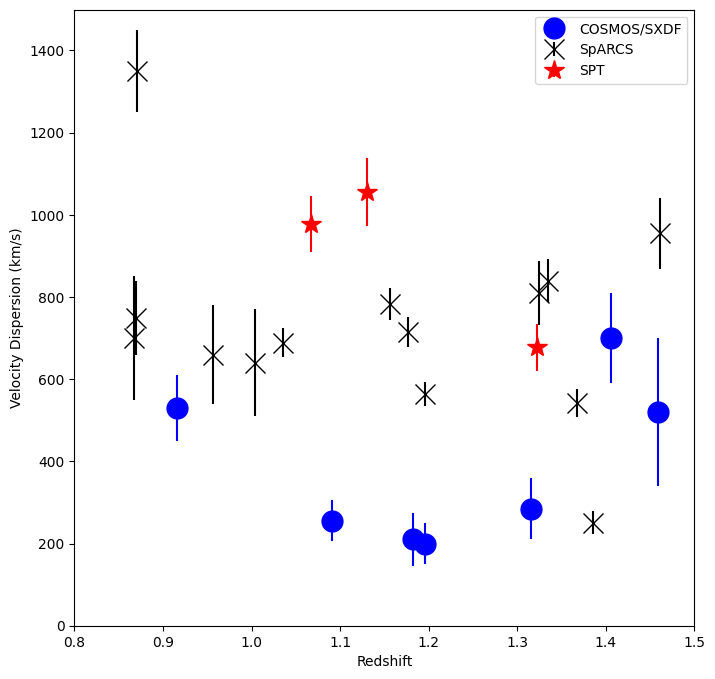

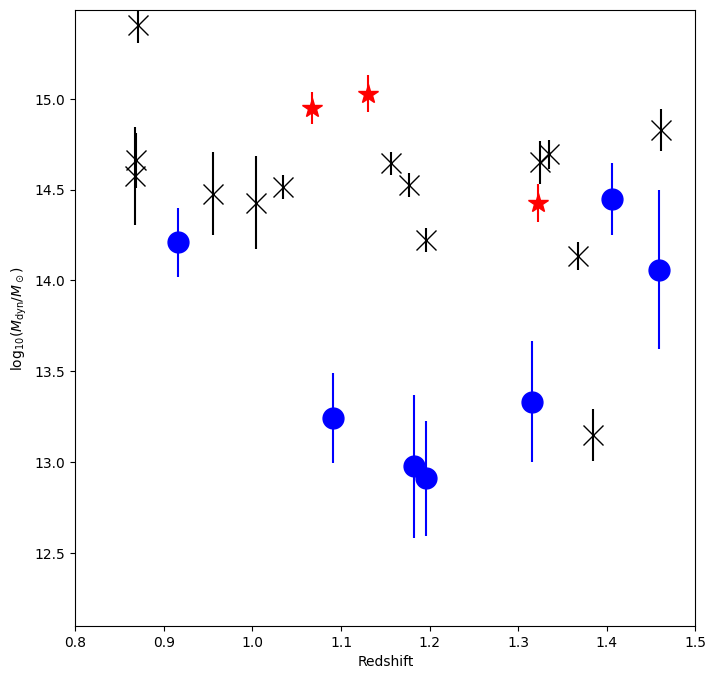

In [13]:
zred, sigma, sigma_err, cluster_id = cluster_table[['redshift','vdisp','vdisp_err','cluster_id']].values.T

groups = np.where( (cluster_id == 13) | (cluster_id == 14) )
sparcs = np.where( ((cluster_id>3) & (cluster_id<13)) | (cluster_id>14) )
spt = np.where( (cluster_id<=3) )

fig, ax = plt.subplots(figsize=(8,8))

ax.errorbar( zred[groups], sigma[groups], sigma_err[groups], fmt='o', ms=15, label='COSMOS/SXDF', c='b')
ax.errorbar( zred[sparcs], sigma[sparcs], sigma_err[sparcs], fmt='x', ms=15, label='SpARCS', c='k')
ax.errorbar( zred[spt], sigma[spt], sigma_err[spt], fmt='*', ms=15, label='SPT', c='r')
ax.legend()
ax.set_xlim(0.8,1.5)
ax.set_ylim(0,1499)
ax.set_ylabel('Velocity Dispersion (km/s)')
ax.set_xlabel('Redshift')
fig.show()

(Saro_A,Saro_B,Saro_C) = (939,2.91,0.33)
hz = cosmo.H(zred)
h70 = hz.value / 100.
lSaro_Mass = 15. + Saro_B * np.log10( sigma / (Saro_A*h70**Saro_C) )
dM = Saro_B * sigma_err / sigma / (np.log(10))

fig, ax = plt.subplots(figsize=(8,8))
ax.errorbar(zred[groups], lSaro_Mass[groups], dM[groups], fmt='o', ms=15, label='COSMOS/SXDF', c='b')
ax.errorbar(zred[sparcs], lSaro_Mass[sparcs], dM[sparcs], fmt='x', ms=15, label='SpARCS', c='k')
ax.errorbar(zred[spt], lSaro_Mass[spt], dM[spt], fmt='*', ms=15, label='SPT', c='r')
ax.set_xlim(0.8,1.5)
ax.set_ylim(12.1,15.49)
ax.set_ylabel(r'log$_{10} (M_{\rm dyn}/M_\odot)$ ')
ax.set_xlabel('Redshift')
fig.show()

<a class="anchor" id="plots-colors"></a>
## UVJ colours with membership

Generate Figure 2:  UVJ diagram showing spectroscopic members and nonmembers

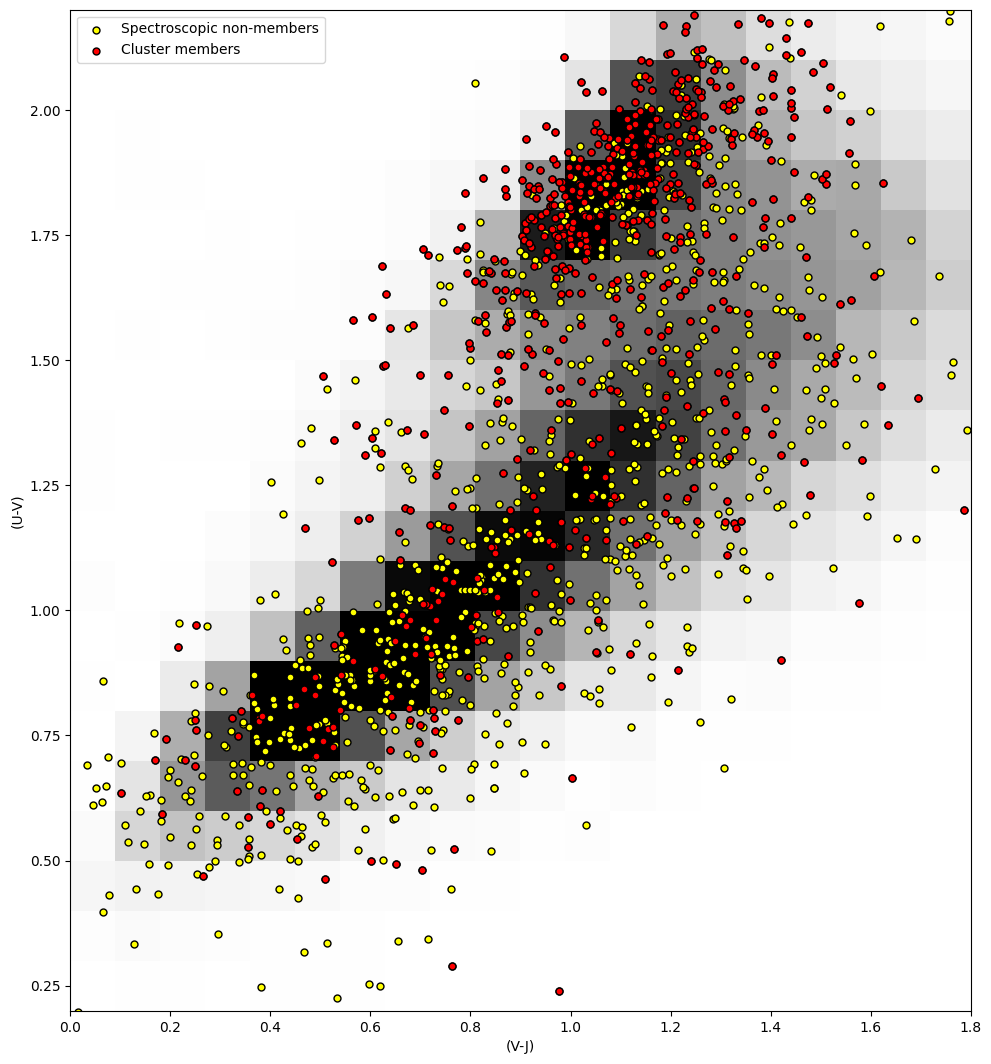

In [14]:
bin_range = ([0,1.8],[0.2,2.2])
cmap = 'gray_r'

# use full photometric catalogue
selection = '(zphot>0.8) & (zphot<1.5) & (mstellar>10**9.5) & (mstellar<10**12)'
UminV,VminJ,photz,mass = phot_table.query(selection)[['uminv','vminj','zphot','mstellar']].values.T
lmass = np.log10(mass)

selection = '(redshift_quality>2) & (redshift>=0.8) & (redshift<=1.5)'
UminVspec,VminJspec,mem = matched_table.query(selection)[['uminv','vminj','member']].values.T

# Show in greyscale all galaxies with stellar mass between 9.5 and 12, and photo-z between 0.8 and 1.5
Nbins = 20
N,xedges,yedges = np.histogram2d( VminJ, UminV, bins=Nbins, range=bin_range)
N = N.T
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
X, Y = np.meshgrid(xedges, yedges)

fig,ax=plt.subplots(1,1,figsize=(13,13))

field = ax.imshow(N, interpolation='nearest', origin='lower',cmap=cmap,vmin=0,vmax=800,extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

ax.scatter(VminJspec, UminVspec, c='yellow', edgecolor='k', alpha=1, s=25, label='Spectroscopic non-members')

ax.scatter(VminJspec[mem==1], UminVspec[mem==1], c='red', edgecolor='k', alpha=1, s=25, label='Cluster members')

ax.legend()
ax.set_ylim(0.2,2.2)
ax.set_xlim(0,1.8)
ax.set_xlabel("(V-J)")
ax.set_ylabel("(U-V)")
fig.show()

<a class="anchor" id="plots-compare-redshifts"></a>
##  Compare spectroscopic and photometric redshifts
Generate Figure 4:  Difference between specz and photoz 

Outliers: 0.2245
rms:  0.0566
Outliers: 0.1322
rms:  0.0543
Outliers: 0.0432
rms:  0.0445
Outliers: 0.0718
rms:  0.0477


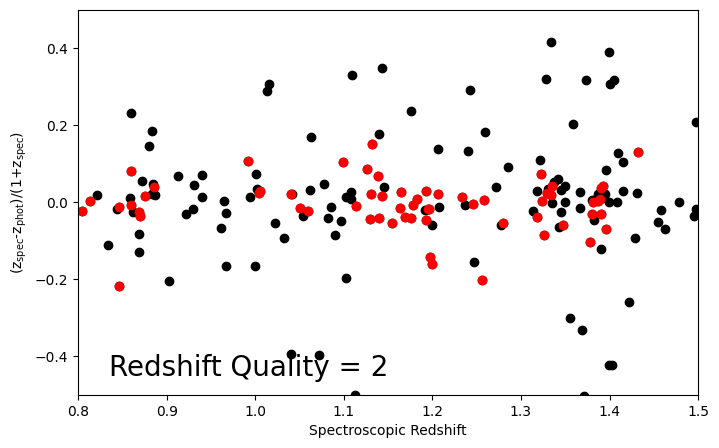

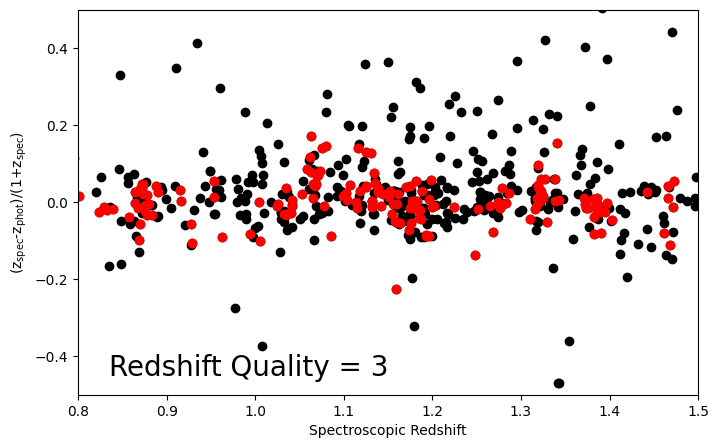

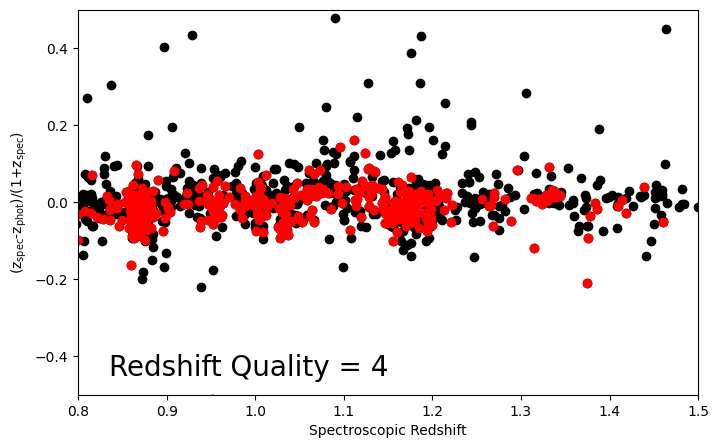

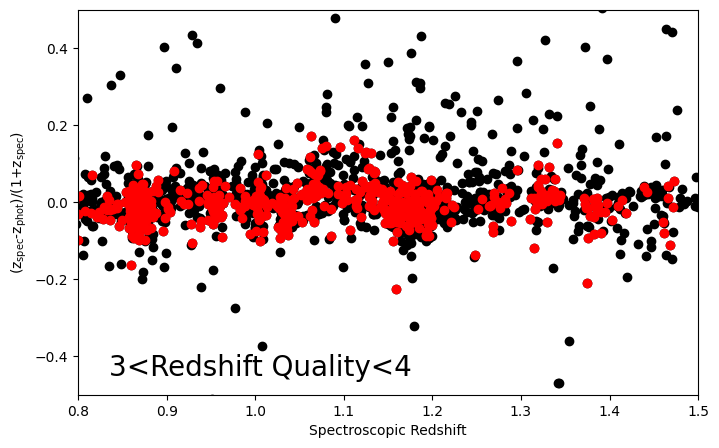

In [15]:
def zspeczphot(qflag1=3, qflag2=10):
    selection = '(zphot>0) & (redshift>=0.7) & (redshift<=1.5) & (redshift_quality>={}) & (redshift_quality<={})'.format(qflag1, qflag2)
    zspec, zphot, uminv, vminj = matched_table.query(selection)[['redshift','zphot','uminv','vminj']].values.T
    
    quiescent = np.where( (vminj<1.5) & (uminv>1.3) & (uminv>vminj*0.88+0.59))
    dz = (zspec-zphot)/(1.+zspec)
    outlier = np.where(np.abs(dz) > 0.15)
    good = np.where(np.abs(dz) <= 0.15)
    N = np.size(zspec)
    Noutlier = np.size(zspec[outlier])
    print ('Outliers: {:.4f}'.format(Noutlier*1./N))
    print ('rms:  {:.4f}'.format(np.std(dz[good])))
    
    fig,ax = plt.subplots(figsize=(8,5))
    ax.scatter(zspec, dz, c='k', marker='o')
    ax.scatter(zspec[quiescent], dz[quiescent], c='r')
    
    if (qflag1 == qflag2): label = 'Redshift Quality = {}'.format(qflag1)
    else: label = '{}<Redshift Quality<{}'.format(qflag1,qflag2)
    ax.text(0.05,0.05, label, transform=ax.transAxes, fontsize=20)

    ax.set_xlim(0.8,1.5)
    ax.set_ylim(-0.5,0.5)
    ax.set_ylabel(r'(z$_{\rm spec}$-z$_{\rm phot}$)/(1+z$_{\rm spec}$)')
    ax.set_xlabel('Spectroscopic Redshift')
    fig.show()
    
zspeczphot(qflag1=2, qflag2=2)
zspeczphot(qflag1=3, qflag2=3)
zspeczphot(qflag1=4, qflag2=4)
zspeczphot(qflag1=3, qflag2=4)

<a class="anchor" id="plots-redshift-success"></a>
## Redshift success
Similar to Figure 7 in the paper, showing the fraction of good redshifts as a function of magnitude and photometric redshift, for galaxies with S/N>1 at 8500A.  Note the paper used S/N measured at 8600A so is slightly different.  Further along in this notebook we will calculate S/N at other wavelengths and then recreate Fig 7 exactly.

(22.0, 24.25, 0.0, 1.0)

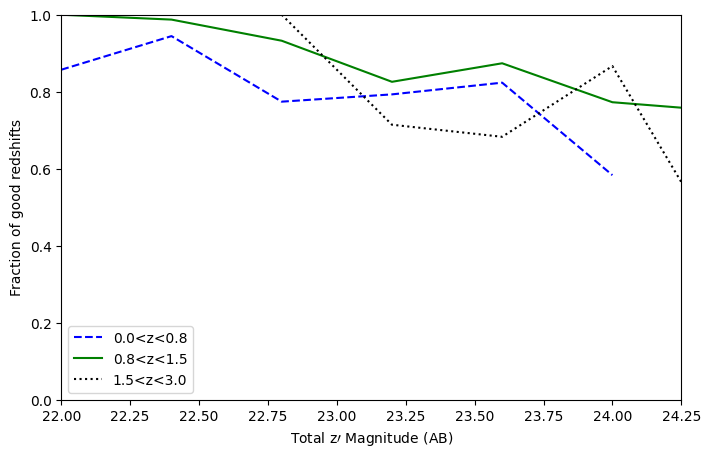

In [16]:
snrlim = 1.0
zp = np.array([(0,0.8),(0.8,1.5),(1.5,3)])
colours = np.array(['blue','green','k','red','magenta'])
lines = np.array(['dashed','solid','dotted'])
nbins = 10

gogreen_select = (matched_table['objclass']==1)  & (matched_table['snr_8500_var']>snrlim) & (matched_table['spec_flag']<2)
goodz = (matched_table['redshift_quality']>=3)
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
cindex = -1
mag = -2.5*np.log10(matched_table['z_tot'])+25
zphot = matched_table['zphot']
for (z1,z2) in zp:
    cindex = cindex+1
    zselect = (zphot>z1) & (zphot<=z2)
    zall,bins = np.histogram(mag[gogreen_select & zselect],bins=nbins,range=(21,25))
    zgood,bins = np.histogram(mag[gogreen_select & goodz & zselect],bins=nbins,range=(21,25))
    xmid = 0.5*(bins[1:]+bins[:-1])

    select = np.where(zall>5)
    plt.plot(xmid[select],zgood[select].astype('float')/zall[select],label=str(z1)+"<z<"+str(z2),c=colours[cindex],linestyle=lines[cindex])
    
plt.xlabel(r"Total z$\prime$ Magnitude (AB)")
plt.legend()
plt.ylabel("Fraction of good redshifts")
ax.axis([22,24.25,0.,1.0])

<a class="anchor" id="plots-mstar-zdistro"></a>
## Stellar mass and redshift distribution
Figure 9 in Data Release paper

Text(0.5, 0, 'Redshift')

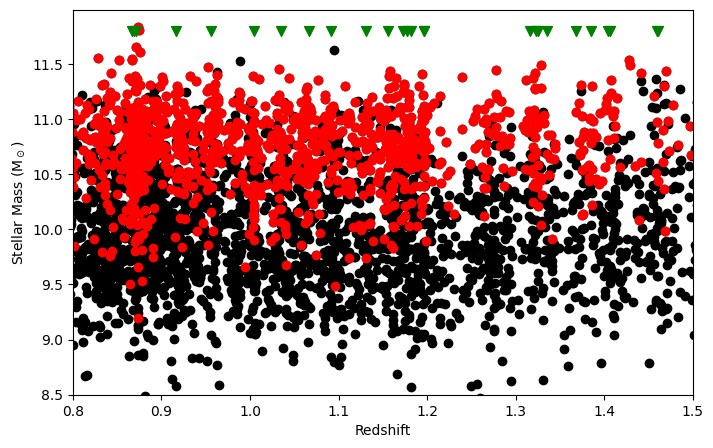

In [17]:
select = '(redshift_quality>{})'.format(2)
redshift,mass,UV,VJ=phot_table.query(select)[['zspec','mstellar','uminv','vminj']].values.T
lmass=np.log10(mass)
Quiescent=((VJ<1.5) & (UV>1.3) & (UV>VJ*0.88+0.59))
fig,ax=plt.subplots(figsize=(8,5))
ax.scatter(redshift,lmass,c='k',marker='o')
ax.scatter(redshift[Quiescent],lmass[Quiescent],c='r')
ax.set_xlim(0.8,1.5)
ax.set_ylim(8.5,11.99)
cm=cluster_table['redshift']*0+11.8
ax.scatter(cluster_table['redshift'],cm,marker='v',c='green',s=50)
ax.set_ylabel(r'Stellar Mass (M$_\odot$)')
ax.set_xlabel('Redshift')

<a class="anchor" id="plots-completeness"></a>
## Completeness plots
Figure 11 in Data Release paper

SpARCS1616 [1.156]
SpARCS1613 [0.871]
SpARCS1051 [1.035]
SpARCS1034 [1.385]
SpARCS1033 [1.461]
SpARCS1047 [0.956]
SpARCS0036 [0.869]
SpARCS0034 [0.867]
SpARCS0035 [1.335]
SXDF64 [0.916]
SXDF49 [1.091]
SpARCS0215 [1.004]
SpARCS0219 [1.325]
SXDF76b [1.182]
SXDF76 [1.459]
SXDF87 [1.406]
SpARCS0335 [1.368]
COSMOS-28 [1.316]
COSMOS-63 [1.1722]
COSMOS-125 [1.404]
COSMOS-221 [1.196]
SpARCS1634 [1.177]
SpARCS1638 [1.196]
SPT2106 [1.13066]
SPT0546 [1.0669]
SPT0205 [1.3227]


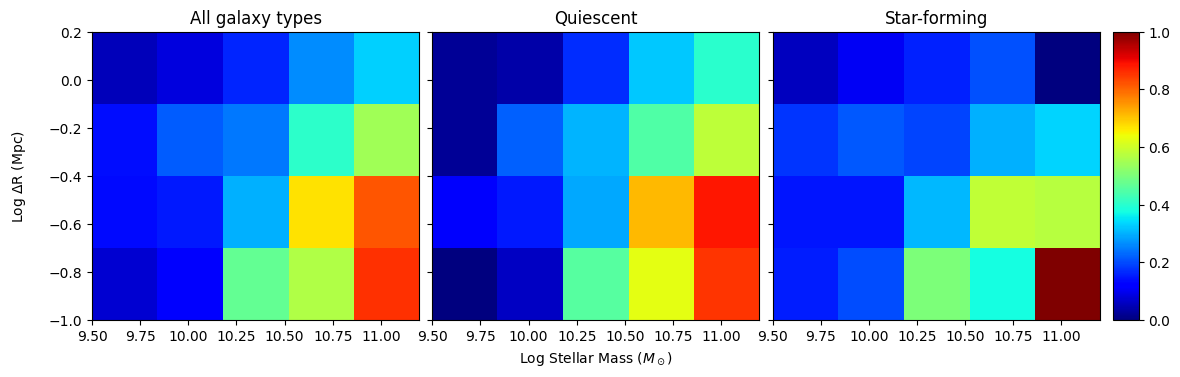

In [18]:
# Define range of stellar masses and log(dr_phys) to plot
range=([9.5,11.2],[-1,0.2])
# Number of bins in each dimension
Nbins=(5,4)
photzrange=0.1
# To look at a single cluster by name
#clusters=np.array(['SpARCS1634'])
# To look at a range of clusters selected by cluster_id
#selection = '(cluster_id>={}) & (cluster_id<{}) '.format(1,2)
#clusters=cluster_table.query(selection)['cluster']
# To combine all clusters:
clusters=None
cmap='jet'
cnt=0

phot_table['lmstellar']=np.log10(phot_table['mstellar'])
if clusters is None: clusters=cluster_table['cluster']
for cluster in clusters:
    cselection = '(cluster=="{}")'.format(cluster)
    cluster_z,cluster_RA,cluster_DEC=cluster_table.query(cselection)[['redshift','ra_best','dec_best']].values.T
    clusterpos=SkyCoord(ra=cluster_RA*u.deg,dec=cluster_DEC*u.deg,frame='icrs')
    print (cluster,cluster_z)
    cnt+=1
    # This doesn't match what is in the paper.  Need l68 and u68.
    phot_table['dz_u']=phot_table['zphot_u68']-cluster_z
    phot_table['dz_l']=phot_table['zphot_l68']-cluster_z
    photselect='(lmstellar>{}) & (lmstellar<{}) & (dz_l<0) & (dz_u>0) & (star<{})'.format(range[0][0],range[0][1],1)
    specselect='(lmstellar>{}) & (lmstellar<{}) & (dz_l<0) & (dz_u>0) & (star<{}) & (redshift_quality>={})'.format(range[0][0],range[0][1],1,3)
    catpos=SkyCoord(ra=phot_table.query(photselect)['ra'].values.T*u.deg,dec=phot_table.query(photselect)['dec'].values.T*u.deg,frame='icrs') 
    UV=phot_table.query(photselect)['uminv'].values.T
    VJ=phot_table.query(photselect)['vminj'].values.T
    ZQ=phot_table.query(photselect)['redshift_quality'].values.T
    masses=phot_table.query(photselect)['lmstellar'].values.T

    dr=catpos.separation(clusterpos)
    DA=cosmo.angular_diameter_distance(cluster_z)
    dr_phys=dr.radian*DA
    dr_phys=np.log10(dr_phys.value+0.0001)

    withspec=(ZQ>=3)
    Quiescent=((VJ<1.5) & (UV>1.3) & (UV>VJ*0.88+0.59))
    # Bin by radius and stellar mass
    N,xedges,yedges=np.histogram2d(masses,dr_phys,bins=Nbins,range=range)
    Nq,xqedges,yqedges=np.histogram2d(masses[Quiescent],dr_phys[Quiescent],bins=Nbins,range=range)

    Ns,xedges,yedges=np.histogram2d(masses[withspec],dr_phys[withspec],bins=Nbins,range=range)
    Nqs,xqedges,yqedges=np.histogram2d(masses[withspec & Quiescent],dr_phys[withspec & Quiescent],bins=Nbins,range=range)

    # There's certainly a more elegant way to do this but I don't know what it is.
    if (cnt==1):
        Ntotal=N.T
        Nqtotal=Nq.T
        Nstotal=Ns.T
        Nqstotal=Nqs.T
    else:
        Ntotal+=N.T
        Nqtotal+=Nq.T
        Nstotal+=Ns.T
        Nqstotal+=Nqs.T
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
X, Y = np.meshgrid(xedges, yedges)
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(13,4),sharey=True,sharex=True)
cbax=fig.add_axes([0.91,0.16,0.02,0.72])
fig.subplots_adjust(wspace=0.04,bottom=0.16)
#print (Ntotal,Nstotal)
#print (Nqtotal,Nqstotal)
H=Nstotal/Ntotal
Hq=Nqstotal/Nqtotal
HSF=(Nstotal-Nqstotal)/(Ntotal-Nqtotal)
all=ax1.imshow(H, interpolation='nearest', origin='lower',cmap=cmap,vmin=0,vmax=1,extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax1.set_aspect('auto')
ax1.set_title('All galaxy types')
Q=ax2.imshow(Hq, interpolation='nearest', origin='lower',cmap=cmap,vmin=0,vmax=1,extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax2.set_aspect('auto')
ax2.set_title('Quiescent')
SF=ax3.imshow(HSF, interpolation='nearest', origin='lower',cmap=cmap,vmin=0,vmax=1,extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax3.set_aspect('auto')
ax3.set_title('Star-forming')
ax1.set_ylabel(r"Log $\Delta$R (Mpc)",labelpad=15)
ax2.set_xlabel(r"Log Stellar Mass ($M_\odot$)")
fig.colorbar(all,cax=cbax)
fig.set_tight_layout(False)
fig.show()

## The following scripts require access to more than just the main catalogues

<a class="anchor" id="plots-spectrum"></a>
## Plot spectrum
This requires access to the 1D spectra, in SPECTROSCOPY/OneD

In [19]:
# Here I'm going to query the dataframe to find an object, and eventually pull up its spectrum
obj = redshift_table.query('(cluster == "{}") & (extver == {})'.format('COSMOS-125', 30))
print(obj)

          elat        elon      glat        glon     htm9   nest4096  ring256  \
1972 -9.232442  151.909879  42.50233  237.269226  3709735  111644132   378796   

         specid        ra       dec  d4000  delta_bic  ed4000  eewhdelta  \
1972  114083269  150.6215  2.158849    NaN        NaN     NaN        NaN   

      eewoii  eewoii_model  ef_oii  esfr_oii  ewhdelta  ewoii  ewoii_model  \
1972     NaN           NaN     NaN       NaN       NaN    NaN          NaN   

      f_oii  member  member_clean  member_em  random_id  redshift  sfr_oii  \
1972    NaN      -1            -1         -1   16.90027   1.52209      NaN   

      snr_8500_rms  snr_8500_var  spec_flag  extver  objclass  \
1972      9.930953     12.166159          0      30         1   

      redshift_quality     cluster  
1972                 7  COSMOS-125  


In [20]:
def get_wavelength_from_hdu(hdr):
    """
    get_wavelength_from_hdu(hdr)

    :param hdu: Fits table header

    Reads 'CRVAL1' 'NAXIS1' and 'CD1_1' to compute wavelength coverage
    """
    return np.arange(hdr['CRVAL1'], hdr['CRVAL1']+hdr['NAXIS1']*hdr['CD1_1'], hdr['CD1_1'])

def get_spectrum(hdu, extver, units='fl', return_frame='observed', redshift=0., objclass=None, bounds=None):
    """
    get_spec(hdu, index, index_var, z=0., scale=1.e-15, bounds=None, units='Fl')

    :param hdu:       Fits table hdu object
    :param index:     Extension of science frame
    :param index_var: Extension of variance frame
    :param return_frame:  What frame to return the wavelength units in. If 'rest', a redshift is required.
    :param redshift:  Redshift of galaxy to convert to rest-frame, if redshift = 0 returns observed-frame
    :param units:     Units of output spectrum, case insensitive

    :type units:      string, "Fl" or "Jy"
    :returns:         wavelengths, the spectrum, and the variance

    Access spectrum from fits file, convert to specified units in rest frame

    Note: Input spectrum must be in units erg cm^-2 s^-1 A^-1
    Note: Header values must give wavelength in Angstroms
    """
    import astropy.units as u

    extver = int(extver)

    units = units.lower()
    assert units in ['fl','maggies','fnu'], 'Error, units must be "Fl" or "maggies"'
    return_frame = return_frame.lower()
    assert return_frame in ['rest','observed'], 'Error, return_frame must be either "rest" or "observed"'

    scale = hdu['SCI',extver].header['FLUXSCAL']
    spec = hdu['SCI',extver].data / scale
    var = hdu['VAR',extver].data / scale**2
    lam = get_wavelength_from_hdu(hdu['SCI',extver].header)

    if objclass==4:
        spec, var = fix_bad_gclass_spec(lam, spec, var, bounds, frame='observed', redshift=redshift)

    if return_frame == 'rest': # convert from observed to rest wavelength
        assert redshift >= 0, 'ERROR: redshift must be positive, is {}'.format(redshift)
        from astropy.cosmology import WMAP9 as cosmo

        dl = (cosmo.luminosity_distance(redshift).to(u.pc).value / 10.)**(-2)
        spec *= (1. + redshift) / dl
        var *= ((1. + redshift) / dl)**2
        lam /= (1. + redshift)

    if units == "maggies":
        convers = (3.34e4 * lam**2)/3631.
        spec *= convers
        var *= convers**2
    elif units == "fnu":
        convers = (3.34e4 * lam**2)
        spec *= convers
        var *= convers**2

    return lam, spec, var


In [21]:
# dataframes often work better when you know its index. 
# Add '.index' at the end to return a 'list' of the indices that match your query
obj = redshift_table.query('(cluster=="{}") & (specid == {})'.format('SpARCS0034', 215021053))
obj_index = obj.index.values[0] # take the first index value

# Open the fits table and get the spectrum in the observed frame
# This code is written with a few options: 
#       return_frame = observed or rest (need a redshfit)
#       units = Fl or Maggies 

#print(sc.ls('gogreen_dr2://SPECTROSCOPY/OneD',format='long'))

fits_path = oneddir + 'SpARCS0034_final.fits'

#with fits.open(fits_path) as hdu:
with fits.open(BytesIO(sc.get(fits_path))) as hdu:
    lam, spec, var = get_spectrum(hdu, redshift_table.loc[obj_index,'extver'], return_frame='observed') # get observed frame spectra


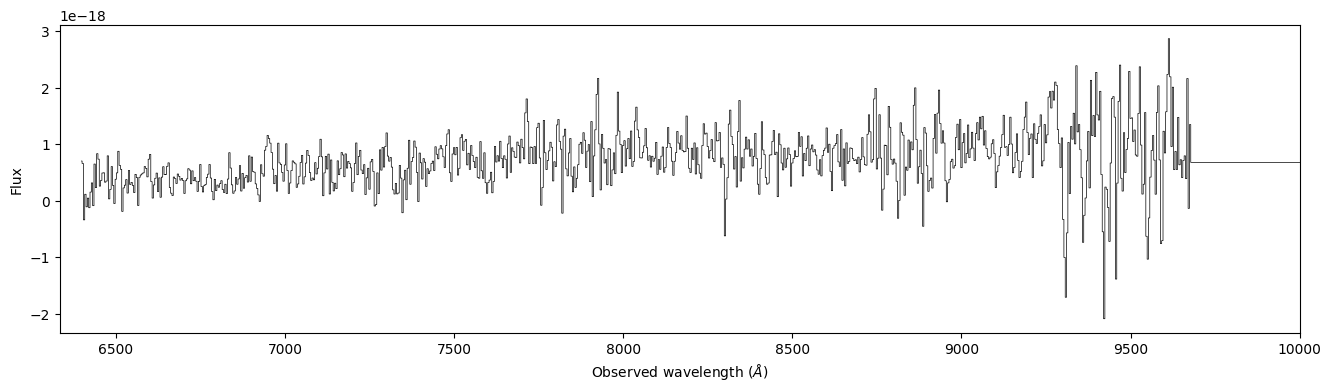

In [22]:
fig, ax = plt.subplots(1,1, figsize=(16,4))
ax.step(lam, spec, color='k', where='mid', lw=0.5)
ax.set(xlabel='Observed wavelength (${\AA}$)', ylabel='Flux', yscale='linear', 
       xlim=[0.99*np.min(lam), 10000])
plt.show()

<a class="anchor" id="plots-redshift-success-vs-snr"></a>
## Redshift success as a function of spectral SNR
Fig 6 in Data Release paper.  Requires measuring the S/N at different wavelengths.
First, a routine to calculate the S/N at different wavelengths, and save it to a file.  We can either take the noise from the VAR array (SNR_VAR) or measure the RMS in the spectrum at the wavelength of interest (SNR_RMS)

In [23]:
def recalcSNR(snr_central=np.arange(8000,9801,200),dwave=200):
    oldcluster = 'None'
    outfilename = 'SNR.txt'
    outfile = open(outfilename,"w+")
    outfile.write("#Cluster EXTVER SPECID ")
    for w in snr_central:
        outfile.write("SNR_"+str(w)+"_VAR SNR_"+str(w)+"_RMS ")
    outfile.write("\n")
    for i in np.arange(np.size(redshift_table['specid'])):
        if i % 500 == 0:
            print(i)
        cluster = redshift_table['cluster'][i]
        ext = redshift_table['extver'][i]
        specid = redshift_table['specid'][i]
        if cluster != oldcluster:
            try:
                MEF.close()
            except:
                pass
            oldcluster = cluster
            onedfile = oneddir + cluster + '_final.fits'
            MEF = fits.open(BytesIO(sc.get(onedfile)))  # getting raw bytes from the file service via sc.get()
        signal = MEF['sci',ext].data
        variance = MEF['var',ext].data
        header = MEF['sci',ext].header
        crval1 = header['CRVAL1']
        crpix1 = header['CRPIX1']
        cd1_1 = header['CD1_1']
        outfile.write("%s %d %d " % (cluster,ext,specid))
        for w in snr_central:
            wave=np.array([w-dwave,w+dwave])
            pix=((wave-crval1)/cd1_1+crpix1).astype(int)
            snr_var=np.average(signal[pix[0]:pix[1]]/np.sqrt(variance[pix[0]:pix[1]]))        
            if ((np.std(signal[pix[0]:pix[1]]))>0):
                snr_rms=np.average(signal[pix[0]:pix[1]])/np.std(signal[pix[0]:pix[1]])
            else:
                snr_rms=0
            outfile.write("%f %f " % (snr_var,snr_rms))
        outfile.write("\n")
    outfile.close()

In [24]:
recalcSNR()

0
500
1000
1500
2000
2500


<a class="anchor" id="plots-redshift-success-2"></a>
## Redshift success Part II
Now we can make Figure 7 in the paper, by restricting to galaxies with S/N>1 at 9600 A. 

(22.0, 24.25, 0.0, 1.0)

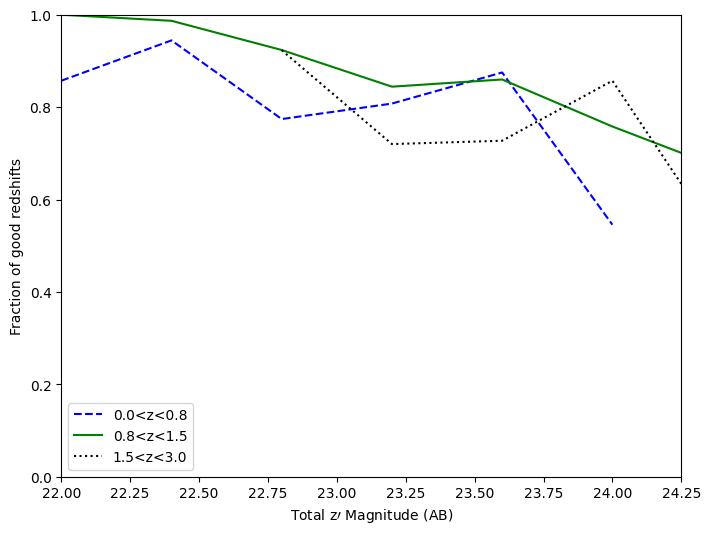

In [25]:
snrlim = 1.0
snrwave = 9600
zp = np.array([(0,0.8),(0.8,1.5),(1.5,3)])
colours = np.array(['blue','green','k','red','magenta'])
lines = np.array(['dashed','solid','dotted'])
nbins = 10

#snrfile=catdir+'SNR.txt'
snrfile = 'SNR.txt'
snrdata = ascii.read(snrfile)
snr_rms = snrdata['SNR_'+str(snrwave)+'_RMS']
snr_var = snrdata['SNR_'+str(snrwave)+'_VAR']
gogreen_select = (matched_table['objclass']==1)  & (snr_var>snrlim) & (matched_table['spec_flag']<2)
goodz = (matched_table['redshift_quality']>=3)
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
cindex = -1
mag = -2.5*np.log10(matched_table['z_tot'])+25
zphot = matched_table['zphot']
for (z1,z2) in zp:
    cindex = cindex+1
    zselect = (zphot>z1) & (zphot<=z2)
    zall,bins = np.histogram(mag[gogreen_select & zselect],bins=nbins,range=(21,25))
    zgood,bins = np.histogram(mag[gogreen_select & goodz & zselect],bins=nbins,range=(21,25))
    xmid = 0.5*(bins[1:]+bins[:-1])

    select = np.where(zall>5)
    plt.plot(xmid[select],zgood[select].astype('float')/zall[select],label=str(z1)+"<z<"+str(z2),c=colours[cindex],linestyle=lines[cindex])
    
plt.xlabel(r"Total z$\prime$ Magnitude (AB)")
plt.legend()
plt.ylabel("Fraction of good redshifts")
ax.axis([22,24.25,0.,1.0])

<a class="anchor" id="plots-snr-vs-mag"></a>
# S/N as a function of magnitude for different populations of galaxies
Fig 3 in the Data release paper

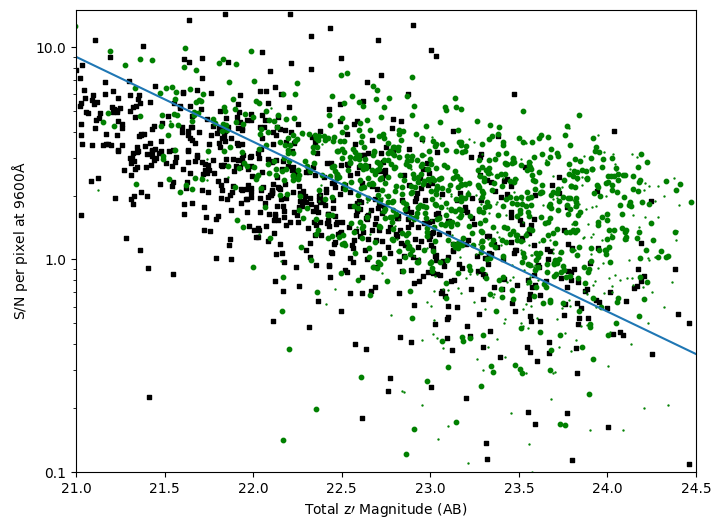

In [26]:
snrwave = 9600
snrfile = 'SNR.txt'
snrdata = ascii.read(snrfile)
snr_rms = snrdata['SNR_'+str(snrwave)+'_RMS']
snr_var = snrdata['SNR_'+str(snrwave)+'_VAR']
zmag = -2.5*np.log10(matched_table['z_tot'])+25
flags = matched_table['spec_flag']
gogreen_select = (matched_table['objclass']==1) 
gclass_select = (matched_table['objclass']==4)
goodz = (matched_table['redshift_quality']>=3)

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(zmag[gclass_select & goodz],snr_rms[gclass_select & goodz],c='k',s=5,marker='s')
ax.scatter(zmag[gogreen_select],snr_rms[gogreen_select],c='g',marker='.',s=2)
ax.scatter(zmag[gogreen_select & goodz],snr_rms[gogreen_select & goodz],c='g',s=10)
snlim = (snr_rms>1.0)
x1 = zmag[goodz & snlim]
x2 = zmag[goodz]
m1 = 21
m2 = 24.5
ax.axis([m1,m2,0.1,15])
y1 = 9
y2 = (10.**(-(m2-m1)/2.5))*y1
plt.plot((m1,m2),(y1,y2))
ax.set_yscale('log')
ax.get_yaxis().set_major_formatter(plticker.ScalarFormatter())
plt.ylabel("S/N per pixel at "+str(int(snrwave))+r"$\mathrm{\AA}$")
plt.xlabel(r"Total z$\prime$ Magnitude (AB)")
fig.show()

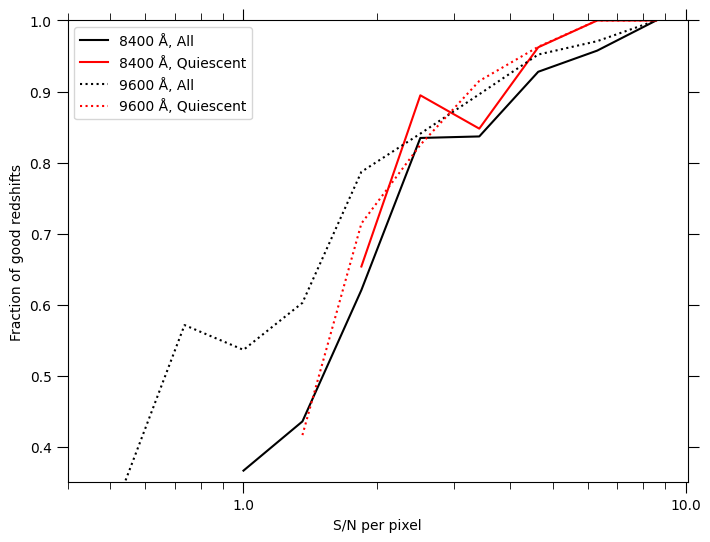

In [27]:
# Specify an array of wavelengths at which you want to measure S/N.  Must correspond to entries in SNR.txt, generated above.
snrwave = np.array([8400,9600])
nbins = 15
colours = np.array(['k','red','blue','green'])
lines = np.array(['solid','dotted','dashed'])
snrfile = 'SNR.txt'
snrdata = ascii.read(snrfile)
flags = matched_table['spec_flag']
VJ = matched_table['vminj']
UV = matched_table['uminv']
Quiescent = (VJ<1.5) & (UV>1.3) & (UV>VJ*0.88+0.59)
zphot = matched_table['zphot']
gogreen_select = (matched_table['objclass']==1) & (flags<2) 
goodz = (matched_table['redshift_quality']>=3)  
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
cindex = -1
for snr in snrwave:
    cindex = cindex+1
    snr_var = snrdata['SNR_'+str(snr)+'_VAR']
    zall_var,bins = np.histogram(np.log10(snr_var[gogreen_select]),bins=nbins,range=(-1,1))
    zgood_var,bins = np.histogram(np.log10(snr_var[gogreen_select & goodz]),bins=nbins,range=(-1,1))
    xmid = 0.5*(bins[1:]+bins[:-1])
    ok = np.where(zall_var>10)
    plt.semilogx(10.**xmid[ok],zgood_var[ok].astype('float')/zall_var[ok],label="%d Å, All" % snr,c='k',linestyle=lines[cindex])
    zall_var,bins = np.histogram(np.log10(snr_var[gogreen_select & Quiescent]),bins=nbins,range=(-1,1))
    zgood_var,bins = np.histogram(np.log10(snr_var[gogreen_select & goodz & Quiescent]),bins=nbins,range=(-1,1))
    xmid = 0.5*(bins[1:]+bins[:-1])
    ok = np.where(zall_var>10)
    plt.semilogx(10.**xmid[ok],zgood_var[ok].astype('float')/zall_var[ok],label="%d Å, Quiescent" % snr,c='red',linestyle=lines[cindex])
plt.xlabel(r"S/N per pixel")
plt.legend()
ax.get_xaxis().set_major_formatter(plticker.ScalarFormatter())
plt.ylabel("Fraction of good redshifts")
plt.tick_params(which='major', length=8,top='on', bottom='on', left='on', right='on')
plt.tick_params(which='minor', length=5,top='on', bottom='on', left='on', right='on')
ax.axis([0.4,10.1,0.35,1.0])
fig.show()

### <a class="anchor" id="plots-summary-object"></a>
## Plot summary of object data
Here is another example of a routine that will plot the 1D and 2D spectrum, together with the I-band image and some other information, for a given object.  To plot the image it nees access to the PHOTOMETRY/IMAGES/ directory, but it should run without it (you just won't get the image)

In [28]:
def markline(ax, name, wavelength, location, ll, y, y1, y2):
    # adds an annotation with vertical line and label
    doline = True
    assert location.lower() in ['below','above'], 'Error: "location" must be either "below" or "above"'
    try:
        range2 = np.where((ll>wavelength*0.995) & (ll<wavelength*1.005) & (y>0))
        s1 = np.min(y[range2])
        s2 = np.max(y[range2])
    except:
        doline = False
    if doline:
        gap = 0.25*(y2-y1)
        if location == 'below':
            textpos = s1-gap
        elif location == 'above':
            textpos = s2+gap
        ax.annotate(name, xy=(wavelength, s2), xytext=(wavelength,textpos), \
                    arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=0))

def plotspecinspect(table, obj_index,filter='I'):
    import matplotlib.patches as patches
    import matplotlib.transforms as transforms
    import matplotlib.ticker as plticker
    import matplotlib.gridspec as gridspec

    from astropy import wcs
    from astropy.convolution import convolve, Box1DKernel

    import os
    
    # make variables of file names
    cluster = table.loc[obj_index,'cluster']
    onedfile = oneddir + cluster + '_final.fits'
    twodfile = twoddir + cluster + '_twod.fits.gz'
    imname = table.loc[obj_index,'image_'+filter].rstrip()
    cdirname = cluster.replace('SPT','SPTCL-').replace('SpARCS','SpARCS-')
    image = imdir + cdirname + '/' + imname + '.fits'
    imageaccess=True
    
    if sc.stat(image) == {}:
        image = image + '.gz'
        
    if sc.stat(image) == {}:
        print ('No image file ',image)
        imageaccess=False
        
    # Get some key information for this object and assign to useful variable names
    # To use the position from the spectroscopy catalogue (image may not align precisely with overlaid slit position)
    #    cols = ['SPECID','EXTVER','Redshift','zphot','Redshift_Quality','RA(J2000)','DEC(J2000)','OBJClass','PA_deg','z_tot','SNR_8500_VAR']
    # To use position from the photometric catalogue
    cols = ['specid','extver','redshift','zphot','redshift_quality','ra','dec','objclass','pa_deg','z_tot','snr_8500_var']
    specid, ext, zspec, zphot, Quality, ra, dec, objclass, pa, z_tot, snr_target = table.loc[obj_index,cols].values.T
    radec = np.array([[ra,dec]])
    usephotoz = False # if redshfit quality below 3, use photmetric redshift instead
    
    zmag_target = -2.5 * np.log10(z_tot)+25
    
    if (Quality<3) & ~np.isnan(zphot): # check redshift quality, if <3 use phot (if exists)
        zred = zphot
        usephotoz = True
    else: 
        zred = zspec
    
    # Create figure
    fig = plt.figure(constrained_layout=True, figsize=(4*4, 4*3))
    gs = gridspec.GridSpec(ncols=4, nrows=3, figure=fig, height_ratios=[1,1,0.8])
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[0, 2:])
    ax4 = fig.add_subplot(gs[1, :])
    
    ##############################
    # 1 - Information panel
    info = '\n'.join([ 'SPECID = {}','ZMAG = {:.1f}','SNR = {:.2f}','OBJCLASS = {}','z = {:.3f}'])
    info = info.format(specid, zmag_target, snr_target, objclass, zred)
    if usephotoz: info += '\nUzing photz'
    else: info += '\nz_Q = {}'.format(Quality)
    
    ax1.axis('off')
    ax1.text(x=0, y=0, s=info, fontsize=20)
    
    ##############################
    # 2 - Postage stamp from preimage
    if imageaccess:
        # Open file
        if image.endswith('.fits'):
            imagedat = fits.open(BytesIO(sc.get(image)))
        elif image.endswith('.fits.gz'):
            imagedat = fits.open(gzip.GzipFile(fileobj=BytesIO(sc.get(image))))
        
        try: 
            im = imagedat[1].data
            im_header = imagedat[1].header
        except:
            im = imagedat[0].data
            im_header = imagedat[0].header
            
        imagedat.close()
        
        # from pixel scale, calculate CCD scale
        imagewcs = wcs.WCS(im_header)
        im_xscale = (np.abs(im_header['CD1_1'])+np.abs(im_header['CD1_2']))*3600
        im_yscale = (np.abs(im_header['CD2_1'])+np.abs(im_header['CD2_2']))*3600
        im = im-np.median(im)
        pixels = imagewcs.wcs_world2pix(radec,0)
        yccd, xccd = pixels[0][0], pixels[0][1]

        # Create postage stamp of galaxy
        defstampsize = 5 / im_xscale * np.array([1,1])
        ximage = [int(np.max([xccd-defstampsize[0]/2+.5,0])),int(np.min([xccd+defstampsize[0]/2+.5,np.shape(im)[0]]))]
        yimage = [int(np.max([yccd-defstampsize[1]/2+.5,0])),int(np.min([yccd+defstampsize[1]/2+.5,np.shape(im)[1]]))]
        centralstampsize = 1 / im_xscale * np.array([1,1])
        xcent = [int(np.max([xccd-centralstampsize[0]/2+.5,0])),int(np.min([xccd+centralstampsize[0]/2+.5,np.shape(im)[0]]))]
        ycent = [int(np.max([yccd-centralstampsize[1]/2+.5,0])),int(np.min([yccd+centralstampsize[1]/2+.5,np.shape(im)[1]]))]
        xstamp = xccd-ximage[0]
        ystamp = yccd-yimage[0]

        ax2.axis('off')
        try:
            im_sub = im[ximage[0]:ximage[1],yimage[0]:yimage[1]]
            minval = np.nanmin(im_sub)
            maxval = np.nanmax(im[xcent[0]:xcent[1],ycent[0]:ycent[1]])
            ax2.imshow(im_sub, vmax=0.99*maxval, vmin=minval, cmap=plt.get_cmap('gray'))
        except:
            pass
        # rectangle: xy=(), width, height
        rect = patches.Rectangle(
            (xstamp-1/2./im_xscale, ystamp-2.25/im_yscale),
            1/im_xscale,
            4.5/im_yscale,
            fill=False,
            edgecolor='red')
        obj = patches.Rectangle(
            (xstamp-1./2./im_xscale, ystamp-0.775/im_yscale),
            1/im_xscale,
            1.55/im_yscale,
            fill=False,
            edgecolor='yellow')
        t = transforms.Affine2D().rotate_deg_around(xstamp,ystamp,pa)
        rect.set_transform(t + ax2.transData)
        obj.set_transform(t + ax2.transData)
        ax2.add_patch(rect)
        ax2.add_patch(obj)
        ax2.scatter(xstamp,ystamp,marker = 'x')
        ax2.set_xlim(0,int(defstampsize[0]))
        ax2.set_ylim(0,int(defstampsize[1]))
    
    
    ##############################
    # 3 - SNR vs ZMAG
    ztots, snrs = matched_table.query('objclass==1')[['z_tot','snr_8500_var']].values.T
    zmags = -2.5*np.log10(ztots) + 25
    
    ax3.scatter(zmags, snrs, facecolor='none', edgecolor='k', s=50)
    ax3.scatter(zmag_target, snr_target, c='r', s=50)
    ax3.set_yscale('log')
    ax3.get_yaxis().set_major_formatter(plticker.ScalarFormatter())
    ax3.set_ylim(0.2,10)
    ax3.set_xlim(20,24.5)
    ax3.set_ylabel("S/N @ 850nm")
    ax3.set_xlabel("ZMAG")
    
    ##############################
    ##### 4 - OneD spectrum
    
    # open file
    with fits.open(BytesIO(sc.get(onedfile))) as onedspec:  # reading file from the file service
        mdf = onedspec['mdf',1].data
        spectrum = onedspec['sci',ext].data
        header_primary = onedspec[0].header
        
        hd = onedspec['sci',ext].header
        var = onedspec['var',ext].data
        unc = np.sqrt( var )
        
    # calculate wavelength array
    pix = np.arange(1,hd['naxis1']+1)
    ll = hd['crval1']+(pix-hd['crpix1'])*hd['cd1_1']
    
    smoothed = convolve(spectrum,Box1DKernel(5)) # smooth spectrum, just for plotting purposes

    ax4.fill_between(ll, spectrum-unc, spectrum+unc, color='yellow', step='mid' )
    ax4.step(ll, spectrum, c='gray', where='mid')
    ax4.step(ll, smoothed, c='k', where='mid')
    ax4.set_xlim(ll[0],ll[-1])
    y1 = np.nanmean(spectrum[:-200])-2.*np.nanstd(spectrum[:-200])
    y2 = np.nanmean(spectrum[:-200])+5.*np.nanstd(spectrum[:-200])

    ax4.set_ylim(y1,y2)
    ax4.set_xlabel("Observed frame wavelength (${\AA}$)")

    # add markers of spectral features
    tax4 = ax4.twiny()
    llz = ll/(1.+zred)

    tax4.set_xlim(llz[0], llz[-1])
    tax4.set_xlabel("Rest frame wavelength (${\AA}$)")
    y1 = np.max([1.e-3,np.min(smoothed)])
    y2 = 1.2*np.max(smoothed)
    
    for label,wl,placement in [['MgII',2800,'above'],
                               ['[OII]',3727,'below'],
                               ['H$\delta$',4102,'above'],
                               ['',4341,'above'],
                               ['H',3970,'above'],
                               ['',3889,'above'],
                               ['',3835,'above'],
                               ["",3797,'above'],
                               ['',3770,'above'],
                               ['CaK',3934,'above'],
                               ['G',4300,'above'],
                               ['FeII',2586,'above'],
                               ['',2600,'above'],
                               ['FeII',2374,'above'],
                               ['',2382.76,'above'],
                               ['FeII',2344,'above'],
                               ['MgI',2850,'above']]:
        
        markline(tax4, label,wl,placement, llz, smoothed, y1, y2)

    ##############################
    ##### 4 - TwoD spectrum sky-subtracted slid with trace
    
    # Open 2D spectrum if it exists
    # Reading raw bits from the file service via sc.get(),
    # then into a BytesIO object (behaves like a file in RAM),
    # then unzipping it with gzip,
    # and finally opening it with astropy.io.fits
    if sc.stat(twodfile) == {}:
        twodexists = False
    else:
        twodexists = True
        with fits.open(gzip.GzipFile(fileobj=BytesIO(sc.get(twodfile)))) as twodspec:
            twod = twodspec['sci',ext].data  

    if twodexists:
        ax5 = fig.add_subplot(gs[2, :])
        maxval = 0.99*np.nanmax(np.abs(np.nanmedian(twod[2:8,950:1100],1)))
        if (maxval<= 0):
            maxval = 0.99*np.nanmax(np.abs(np.nanmedian(twod,1)))
        extent = [ll[0],ll[-1],1,20]
        ax5.imshow(twod[:,:], extent=extent, origin='lower', aspect=10, vmax=maxval, vmin=-maxval, cmap=plt.get_cmap('gray'))
        ax5.set_xlim(ll[0],ll[-1])
        ax5.set_xlabel("Observed frame wavelength (${\AA}$)")
        

    fig.show()

Here's an example of how to use this to generate plots for objects selected based on their cluster, redshift quality and z magnitude. By default this is plotting the J-band image but you can change this by specifying a different filter suffix.

Generating plot for specid  215040522
Generating plot for specid  215030635
Generating plot for specid  215040864


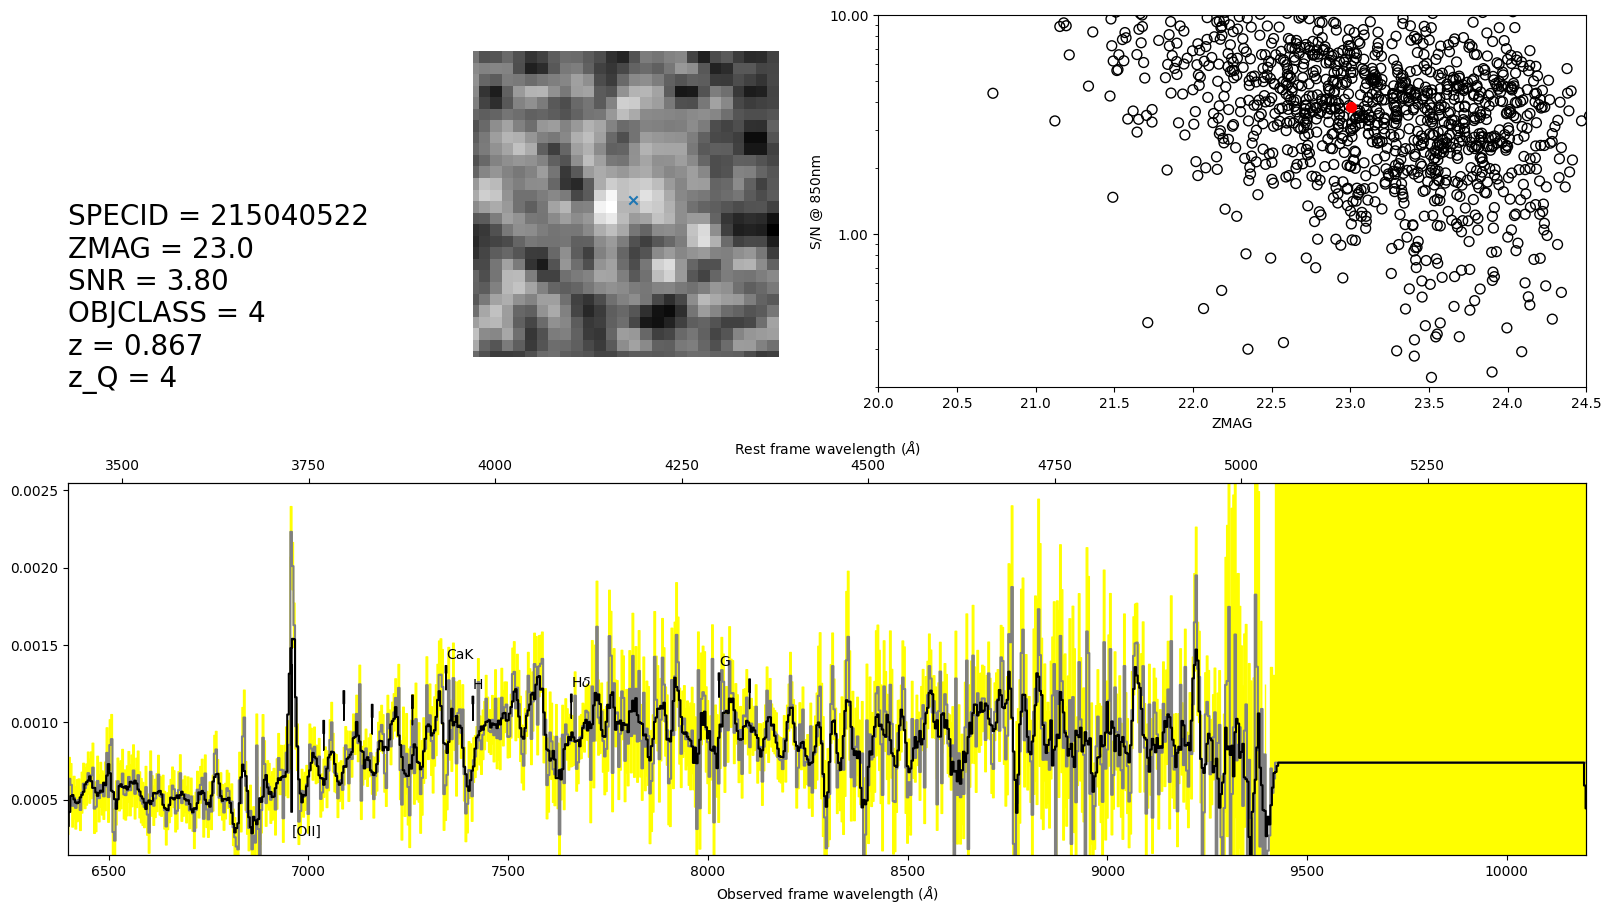

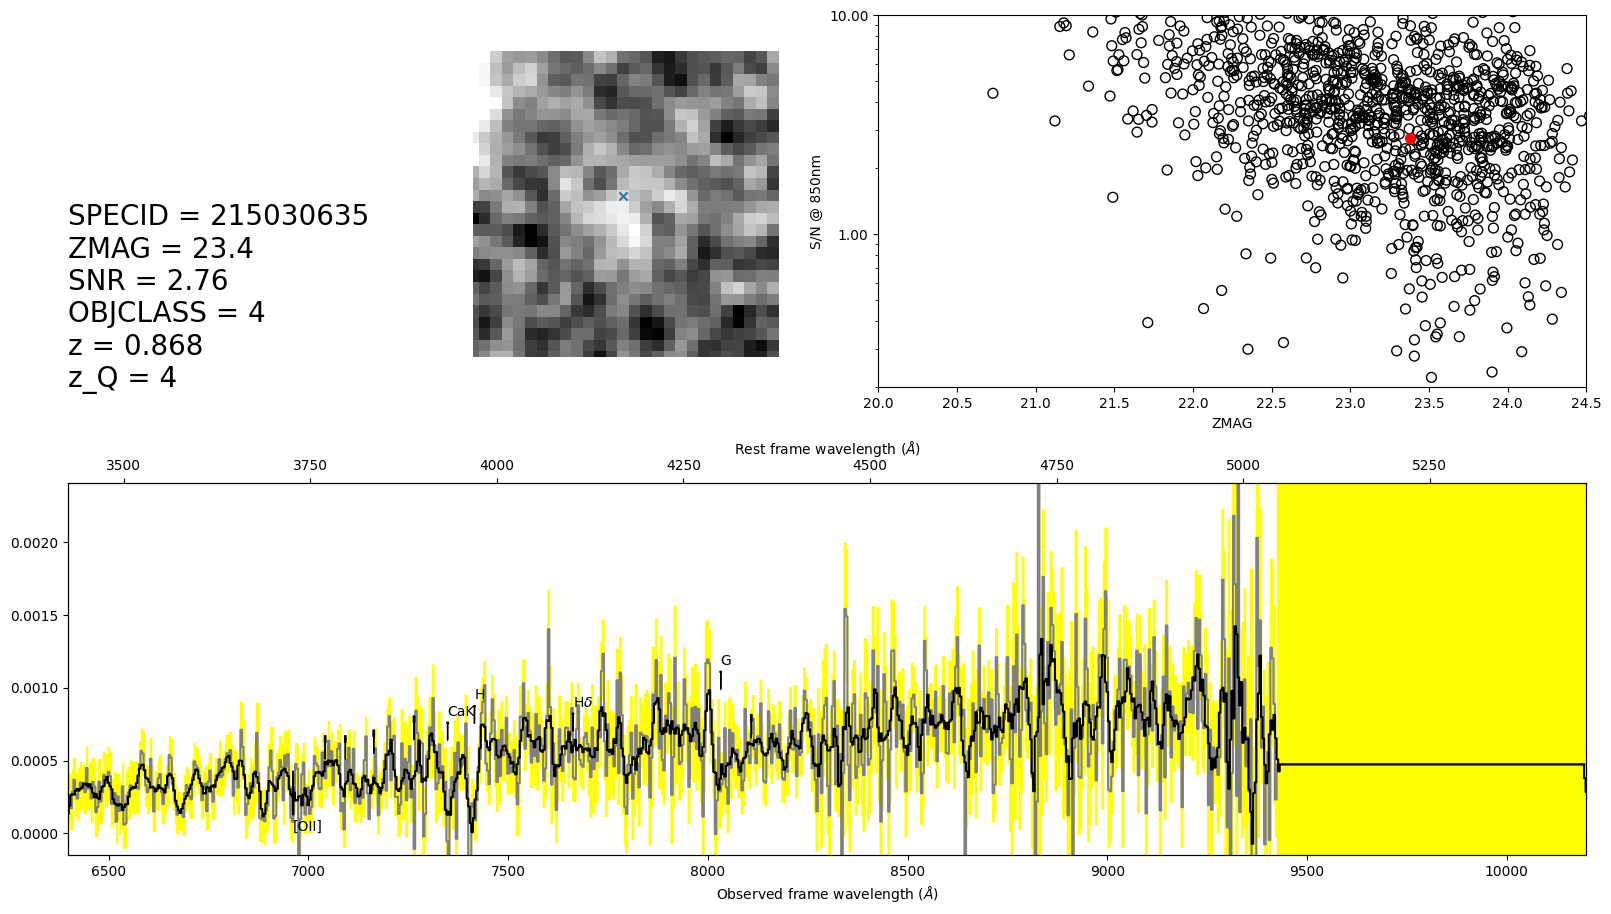

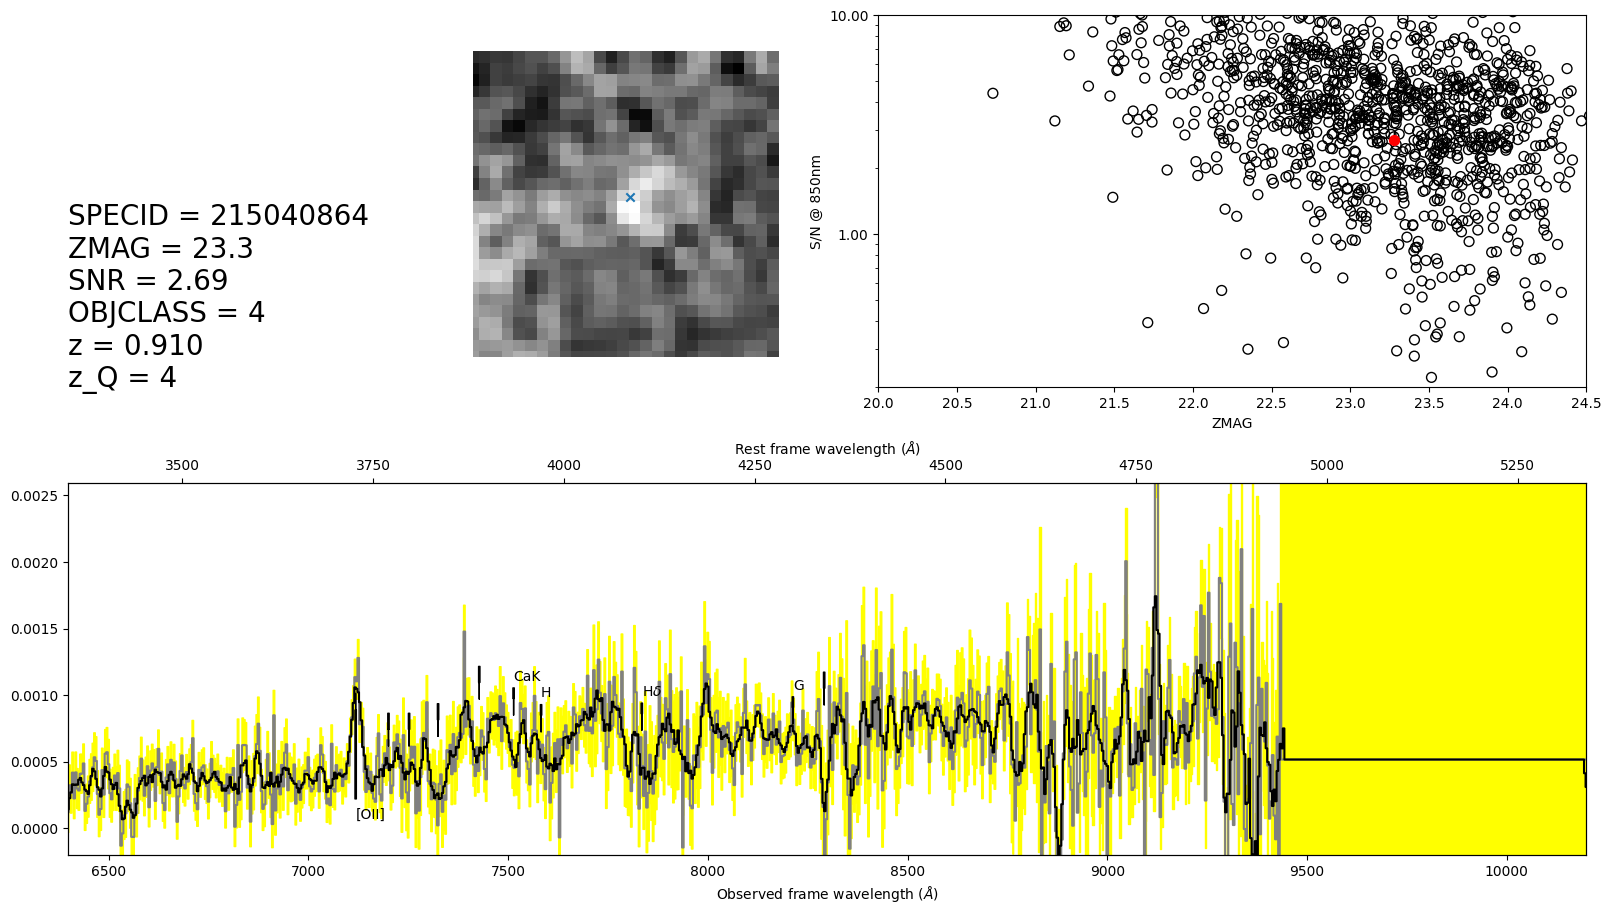

In [29]:
cluster = 'SpARCS0034'
image_filter='j'
zmaglim = np.array([23.5, 23.0])
zfluxlim = 10.**(-0.4*(zmaglim-25.))

objs = matched_table.query('(cluster=="{}") & (redshift_quality == {}) & (z_tot >= {}) & (z_tot <= {})'.format(cluster, 4,zfluxlim[0],zfluxlim[1]))

for obj_index in objs.index.values:
    print ('Generating plot for specid ',matched_table.loc[obj_index,'specid'])
    plotspecinspect(matched_table,obj_index,filter=image_filter)     